In [2]:
library(mgsub)
library(lsa) #cosine
library(tidyverse)
library(ggplot2)
library(corrplot)
library(RColorBrewer)
library(openxlsx)

In [3]:
lowerTriangle <- function(m){
  return(m[lower.tri(m,diag = FALSE)])
}

# R.scale() uses ddof=1, but sklearn.preprocessing.StandardScaler() uses ddof=0
scaleN <- function(data){
  data_scaled <- scale(data)*sqrt(nrow(data)/(nrow(data)-1))  
  return(data_scaled)
}

cosine_matrix = function(raw_data){
    # rel*rel matrix caculated by cosine similarity
    n <- nrow(raw_data)  # raw_data is an n x n matrix, 159*dimensions
    # create an empty matrix to store cosine similarity
    raw_data_cor <- matrix(0, nrow = n, ncol = n)
    colnames(raw_data_cor) <- rownames(raw_data)
    rownames(raw_data_cor) <- rownames(raw_data)
    # calculate the cosine similarity of the upper triangular part
    for (i in 1:(n - 1)) {
        for (j in (i + 1):n) {
            cosine_value <- cosine(as.numeric(raw_data[i, ]), as.numeric(raw_data[j, ]))
            raw_data_cor[i, j] <- cosine_value
        }
    }
    # symmetrically fill the cosine similarity in the lower triangular part
    raw_data_cor <- raw_data_cor + t(raw_data_cor)

    # set the diagonal to 1
    diag(raw_data_cor) <- 1
    return(raw_data_cor)
}

# Human rating

In [7]:
human_scores = read.csv('human_rating_data/human_model/CHN_258r_favee.csv',row.names=1, fileEncoding = 'gb18030')
human_scores = human_scores[,paste0(c('Formality','Activeness','Valence','Exchange','Equality'),'.human')]
rels_modern_order = rownames(human_scores)
# cosine similarity of human rating
human_sim = read.csv('human_rating_data/human_model/human_33d_258r_cosine.csv',
                     row.names = 1, check.names = FALSE, fileEncoding = 'gb18030')
human_sim_array = lowerTriangle(human_sim)

# correlation
human_33d = read.csv('human_rating_data/study2_modern/CHN_dim_rel_NLP_258r_33d_scaled_chi.csv',row.names=1, fileEncoding = 'gb18030')

# Bert embedding

## Modern  
Query3.1: [DESC]The most salient feature of the relationship [TERM] is [MASK].

In [33]:
bert_768d=read.csv('bert_embedding_data/modern/q3.1_bert_embedding_data/MASK_embedding_output.csv',
                   row.names = 1, check.names = FALSE, fileEncoding = 'gb18030')
rownames(bert_768d) = bert_768d$'word'
bert_768d = bert_768d[,-c(1)]
labels_new = read.csv('../1.GPT4_DESC/CHN_modern/labels_chinese.csv', fileEncoding = 'gb18030')
bert_768d = scaleN(bert_768d)
rownames(bert_768d) = mgsub(rownames(bert_768d),labels_new$'query',labels_new$'Relationships')
bert_768d = bert_768d[rels_modern_order,]
dim(bert_768d)

bert_768d_modern_sim = cosine_matrix(bert_768d)
bert_768d_sim_array = lowerTriangle(bert_768d_modern_sim)
raw_bert = cor(human_sim_array,bert_768d_sim_array, method = 'spearman')
raw_bert

[1] 258 768

[1] 0.5528642

In [35]:
r_bert_distri = c()
for (i in (1:10000)){
    sel = sample(258)
    bert_permat = bert_768d_modern_sim[sel,sel]
    bert_rdm = bert_permat[lower.tri(bert_permat,diag = FALSE)]
    r_bert = cor(scale(human_sim_array),scale(bert_rdm))
    r_bert_distri = c(r_bert_distri,r_bert)
}

sum(r_bert_distri>raw_bert)/10000

[1] 0

### FAVEE


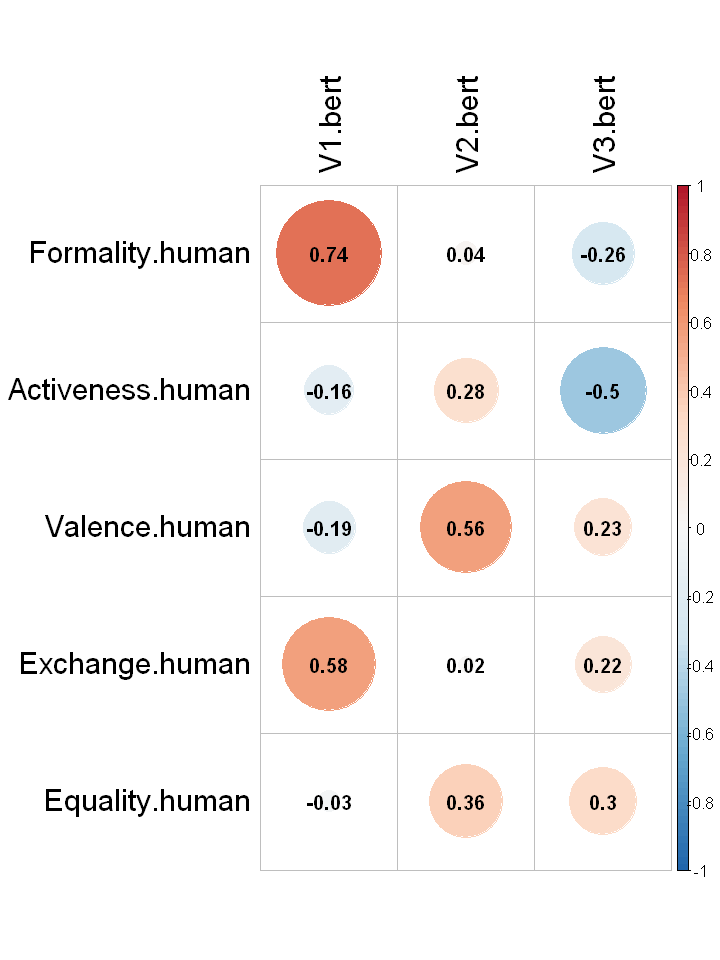

In [9]:
ncomp = 3
dim_rel.pca = prcomp(bert_768d)
loadings_none = dim_rel.pca$rotation[,1:ncomp]%*% diag(dim_rel.pca$sdev,ncomp,ncomp)
scores_none = dim_rel.pca$x[,1:ncomp] 

# pca with varimax rotation
loadings_var = data.frame(varimax(loadings_none)$loadings[,])
scores_var = scale(scores_none) %*% varimax(loadings_none)$rotmat

bert_scores = data.frame(scores_var)
colnames(bert_scores) = paste0('V',seq(1,ncomp),'.bert')

bert_human_combine = cbind(human_scores,bert_scores)
bert_human_cor = cor(bert_human_combine,method='spearman')

options(repr.plot.width=6, repr.plot.height=8)
corrplot(bert_human_cor[1:5,6:length(bert_human_combine)],is.corr=FALSE,
         addCoef.col = "black",
         tl.col="black",tl.cex=1.5,
         col.lim = c(-1,1),
         col = colorRampPalette(rev(brewer.pal(n=7,name ="RdBu")))(100))

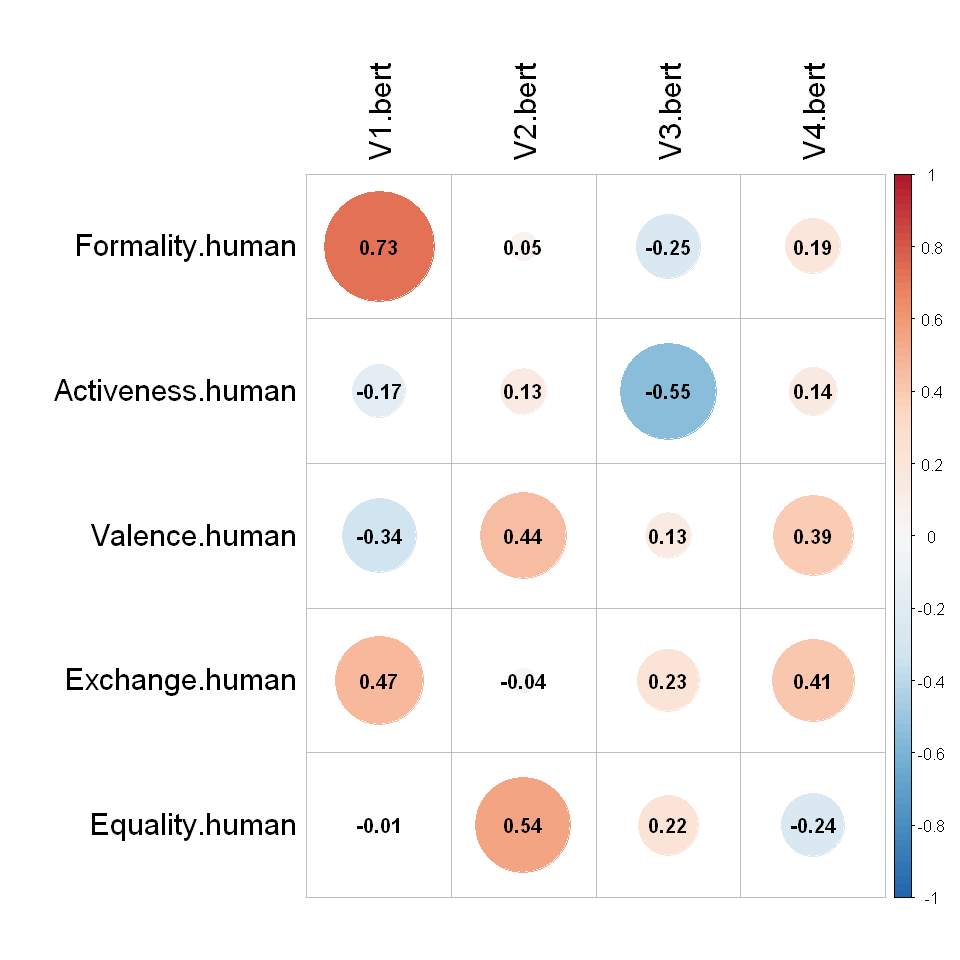

In [12]:
ncomp = 4
dim_rel.pca = prcomp(bert_768d)
loadings_none = dim_rel.pca$rotation[,1:ncomp]%*% diag(dim_rel.pca$sdev,ncomp,ncomp)
scores_none = dim_rel.pca$x[,1:ncomp] 

# pca with varimax rotation
loadings_var = data.frame(varimax(loadings_none)$loadings[,])
scores_var = scale(scores_none) %*% varimax(loadings_none)$rotmat

bert_scores = data.frame(scores_var)
colnames(bert_scores) = paste0('V',seq(1,ncomp),'.bert')

bert_human_combine = cbind(human_scores,bert_scores)
bert_human_cor = cor(bert_human_combine,method='spearman')

options(repr.plot.width=8, repr.plot.height=8)
corrplot(bert_human_cor[1:5,6:length(bert_human_combine)],is.corr=FALSE,
         addCoef.col = "black",
         tl.col="black",tl.cex=1.5,
         col.lim = c(-1,1),
         col = colorRampPalette(rev(brewer.pal(n=7,name ="RdBu")))(100))

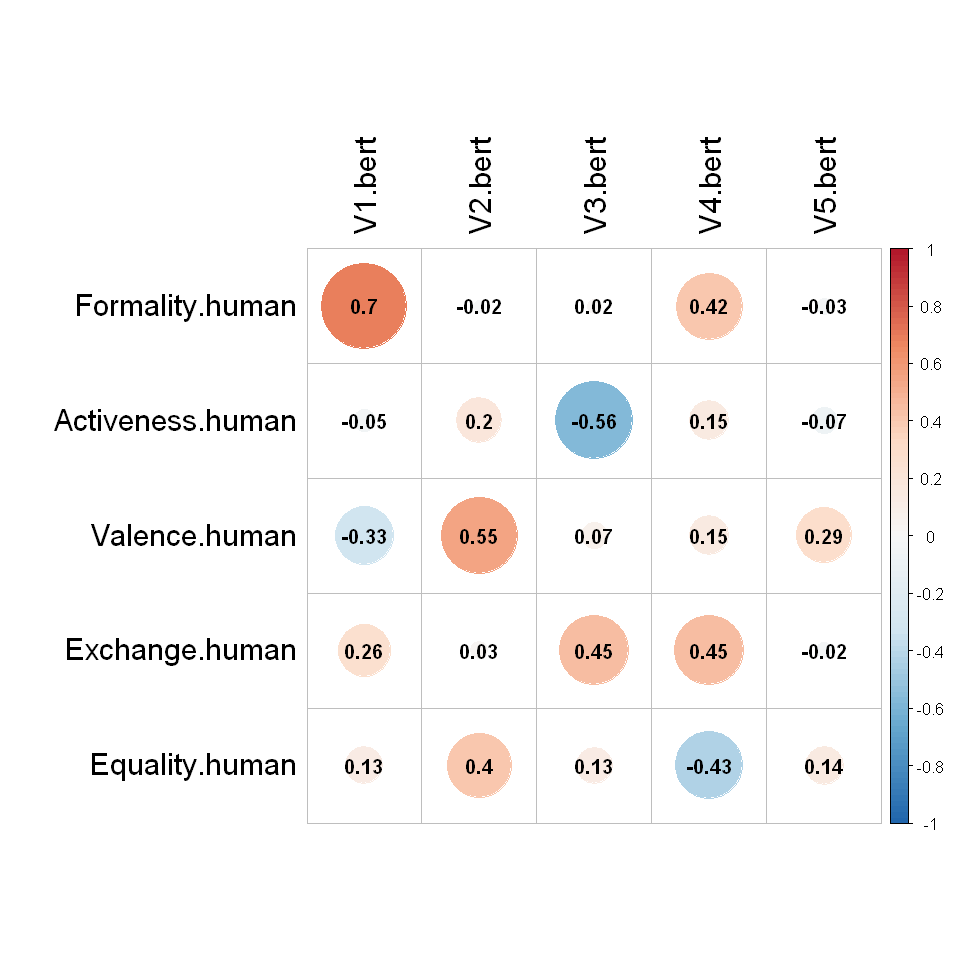

In [13]:
ncomp = 5
dim_rel.pca = prcomp(bert_768d)
loadings_none = dim_rel.pca$rotation[,1:ncomp]%*% diag(dim_rel.pca$sdev,ncomp,ncomp)
scores_none = dim_rel.pca$x[,1:ncomp] 

# pca with varimax rotation
loadings_var = data.frame(varimax(loadings_none)$loadings[,])
scores_var = scale(scores_none) %*% varimax(loadings_none)$rotmat

bert_scores = data.frame(scores_var)
colnames(bert_scores) = paste0('V',seq(1,ncomp),'.bert')

bert_human_combine = cbind(human_scores,bert_scores)
bert_human_cor = cor(bert_human_combine,method='spearman')

options(repr.plot.width=8, repr.plot.height=8)
corrplot(bert_human_cor[1:5,6:length(bert_human_combine)],is.corr=FALSE,
         addCoef.col = "black",
         tl.col="black",tl.cex=1.5,
         col.lim = c(-1,1),
         col = colorRampPalette(rev(brewer.pal(n=7,name ="RdBu")))(100))

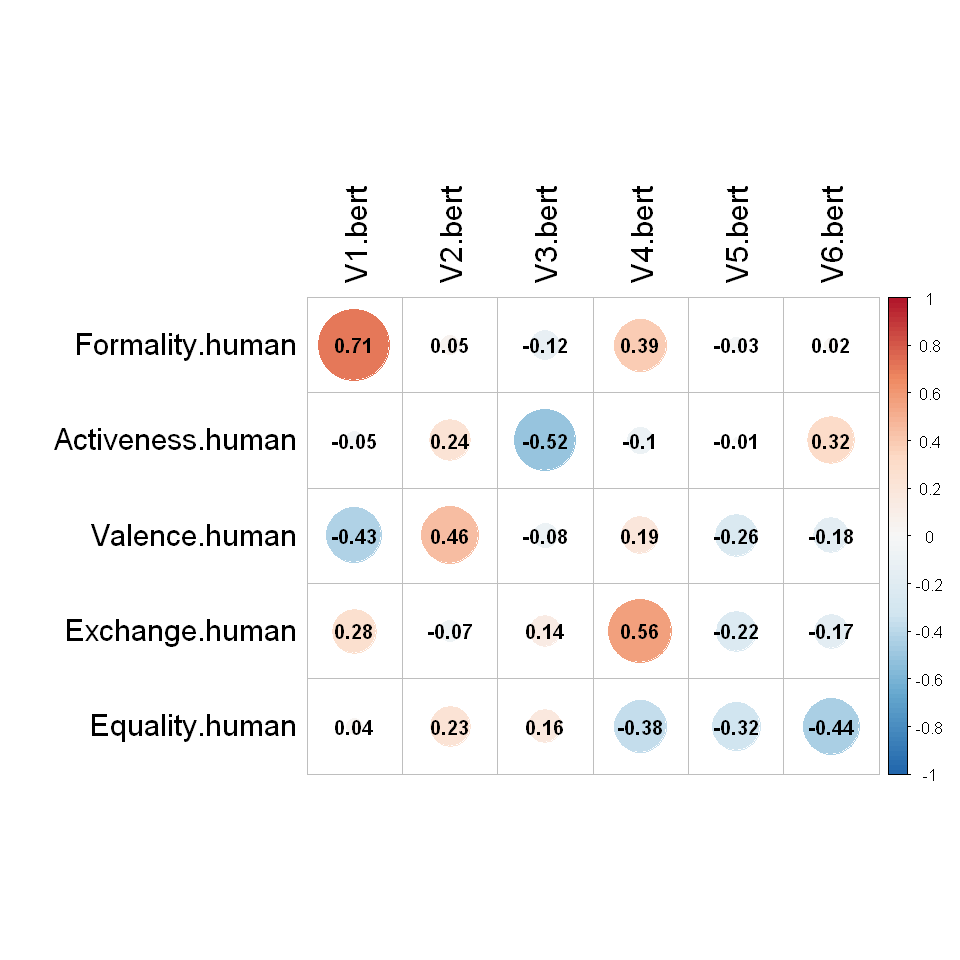

In [14]:
ncomp = 6
dim_rel.pca = prcomp(bert_768d)
loadings_none = dim_rel.pca$rotation[,1:ncomp]%*% diag(dim_rel.pca$sdev,ncomp,ncomp)
scores_none = dim_rel.pca$x[,1:ncomp] 

# pca with varimax rotation
loadings_var = data.frame(varimax(loadings_none)$loadings[,])
scores_var = scale(scores_none) %*% varimax(loadings_none)$rotmat

bert_scores = data.frame(scores_var)
colnames(bert_scores) = paste0('V',seq(1,ncomp),'.bert')

bert_human_combine = cbind(human_scores,bert_scores)
bert_human_cor = cor(bert_human_combine,method='spearman')

options(repr.plot.width=8, repr.plot.height=8)
corrplot(bert_human_cor[1:5,6:length(bert_human_combine)],is.corr=FALSE,
         addCoef.col = "black",
         tl.col="black",tl.cex=1.5,
         col.lim = c(-1,1),
         col = colorRampPalette(rev(brewer.pal(n=7,name ="RdBu")))(100))

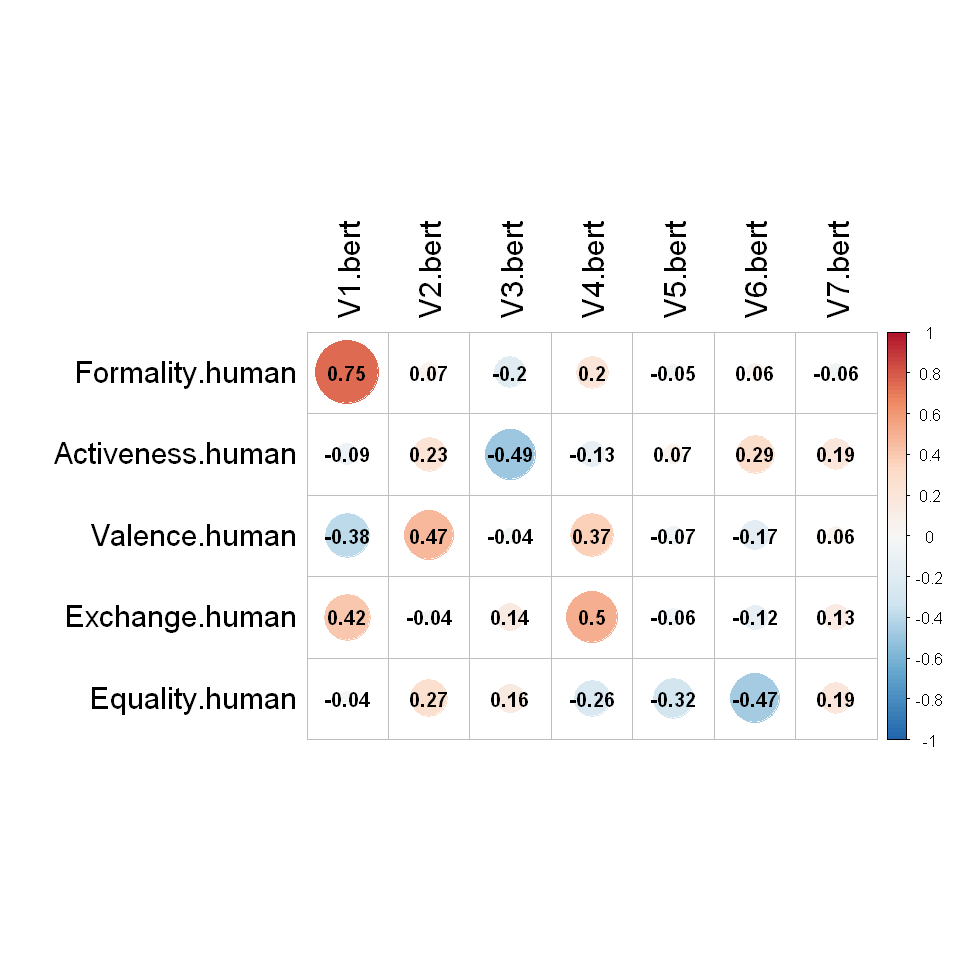

In [15]:
ncomp = 7
dim_rel.pca = prcomp(bert_768d)
loadings_none = dim_rel.pca$rotation[,1:ncomp]%*% diag(dim_rel.pca$sdev,ncomp,ncomp)
scores_none = dim_rel.pca$x[,1:ncomp] 

# pca with varimax rotation
loadings_var = data.frame(varimax(loadings_none)$loadings[,])
scores_var = scale(scores_none) %*% varimax(loadings_none)$rotmat

bert_scores = data.frame(scores_var)
colnames(bert_scores) = paste0('V',seq(1,ncomp),'.bert')

bert_human_combine = cbind(human_scores,bert_scores)
bert_human_cor = cor(bert_human_combine,method='spearman')
bert_scores_modern = bert_scores

options(repr.plot.width=8, repr.plot.height=8)
corrplot(bert_human_cor[1:5,6:length(bert_human_combine)],is.corr=FALSE,
         addCoef.col = "black",
         tl.col="black",tl.cex=1.5,
         col.lim = c(-1,1),
         col = colorRampPalette(rev(brewer.pal(n=7,name ="RdBu")))(100))


	Spearman's rank correlation rho

data:  human_scores$Formality.human and bert_scores$V1.bert
S = 715046, p-value < 2.2e-16
alternative hypothesis: true rho is not equal to 0
sample estimates:
      rho 
0.7501769 



	Spearman's rank correlation rho

data:  human_scores$Activeness.human and bert_scores$V3.bert
S = 4272474, p-value < 2.2e-16
alternative hypothesis: true rho is not equal to 0
sample estimates:
       rho 
-0.4927191 



	Spearman's rank correlation rho

data:  human_scores$Valence.human and bert_scores$V2.bert
S = 1528812, p-value < 2.2e-16
alternative hypothesis: true rho is not equal to 0
sample estimates:
      rho 
0.4658629 



	Spearman's rank correlation rho

data:  human_scores$Exchange.human and bert_scores$V4.bert
S = 1419784, p-value < 2.2e-16
alternative hypothesis: true rho is not equal to 0
sample estimates:
      rho 
0.5039552 



	Spearman's rank correlation rho

data:  human_scores$Equality.human and bert_scores$V6.bert
S = 4193206, p-value < 2.2e-16
alternative hypothesis: true rho is not equal to 0
sample estimates:
       rho 
-0.4650244 


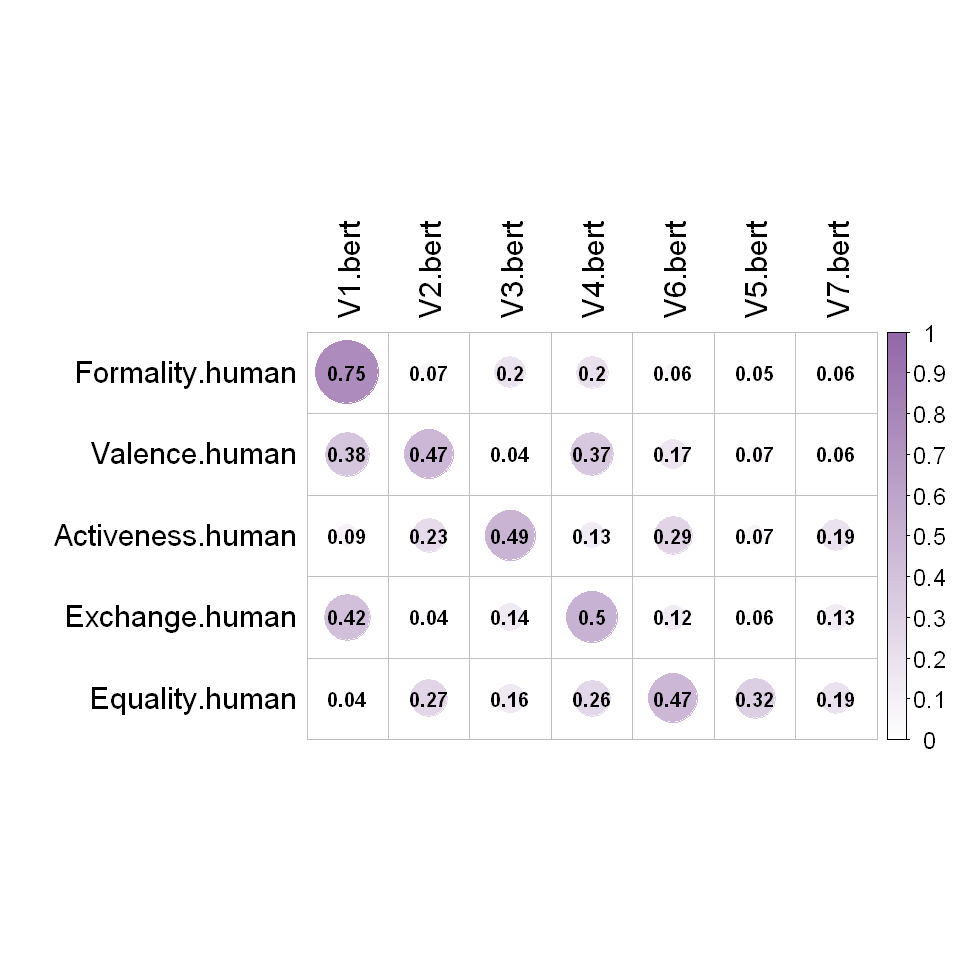

In [22]:
ncomp = 7
dim_rel.pca = prcomp(bert_768d)
loadings_none = dim_rel.pca$rotation[,1:ncomp]%*% diag(dim_rel.pca$sdev,ncomp,ncomp)
scores_none = dim_rel.pca$x[,1:ncomp] 

# pca with varimax rotation
loadings_var = data.frame(varimax(loadings_none)$loadings[,])
scores_var = scale(scores_none) %*% varimax(loadings_none)$rotmat

bert_scores = data.frame(scores_var)
colnames(bert_scores) = paste0('V',seq(1,ncomp),'.bert')

bert_human_combine = cbind(human_scores,bert_scores)
bert_human_cor = cor(bert_human_combine,method='spearman')
bert_scores_modern = bert_scores

options(repr.plot.width=8, repr.plot.height=8)
plot_scores_modern = abs(bert_human_cor)[1:5,6:length(bert_human_combine)]
plot_scores_modern = plot_scores_modern[,paste0('V',c(seq(1,4),c(6,5,7)),'.bert')]
plot_scores_modern = plot_scores_modern[paste0(c('Formality','Valence','Activeness','Exchange','Equality'),'.human'),]
corrplot(plot_scores_modern,is.corr=FALSE,
         addCoef.col = "black",
         tl.col="black",tl.cex=1.5,
         col.lim = c(0,1),cl.cex=1.2,
         col = colorRampPalette(c("white","#9368A8"))(100))

cor.test(human_scores$'Formality.human',bert_scores$'V1.bert',method='spearman')
cor.test(human_scores$'Activeness.human',bert_scores$'V3.bert',method='spearman')
cor.test(human_scores$'Valence.human',bert_scores$'V2.bert',method='spearman')
cor.test(human_scores$'Exchange.human',bert_scores$'V4.bert',method='spearman')
cor.test(human_scores$'Equality.human',bert_scores$'V6.bert',method='spearman')

In [23]:
png("output_graph/Modern_PCA_cor.png", bg="transparent",
    family = 'sans',units='in',width=8,height=8,res=300)
options(repr.plot.width=8, repr.plot.height=8)
plot_scores_modern = abs(bert_human_cor)[1:5,6:length(bert_human_combine)]
plot_scores_modern = plot_scores_modern[paste0(c('Formality','Valence','Activeness','Exchange','Equality'),'.human'),]
plot_scores_modern = plot_scores_modern[,paste0('V',c(seq(1,4),c(6,5,7)),'.bert')]
corrplot(plot_scores_modern,is.corr=FALSE,
         #addCoef.col = "black",
         tl.col="black",tl.cex=1.5,
         col.lim = c(0,1),cl.cex=1.2,
         col = colorRampPalette(c("white","#9368A8"))(100))
dev.off()

png 
  2

In [17]:
# bert_formality_dist = c(dist(bert_scores_modern['V1.bert']))
# cor(lowerTriangle(bert_768d_modern_sim),-bert_formality_dist,method='spearman')

# bert_valence_dist = c(dist(bert_scores_modern['V2.bert']))
# cor(lowerTriangle(bert_768d_modern_sim),-bert_valence_dist,method='spearman')

# bert_activeness_dist = c(dist(bert_scores_modern['V3.bert']))
# cor(lowerTriangle(bert_768d_modern_sim),-bert_activeness_dist,method='spearman')

# bert_exchange_dist = c(dist(bert_scores_modern['V4.bert']))
# cor(lowerTriangle(bert_768d_modern_sim),-bert_exchange_dist,method='spearman')

# bert_equality_dist = c(dist(bert_scores_modern['V6.bert']))
# cor(lowerTriangle(bert_768d_modern_sim),-bert_equality_dist,method='spearman')

# within_cor = cbind(-bert_formality_dist,-bert_activeness_dist,
#                    -bert_valence_dist,-bert_exchange_dist,-bert_equality_dist,
#                    lowerTriangle(bert_768d_modern_sim))
# colnames(within_cor) = c('Formaliy','Activeness','Valence','Exchange','Equality','BERT.modern')
# within_cor_modern = cor(within_cor,method='spearman')
# within_cor_modern

# favee_model_modern = lm(scale(-lowerTriangle(bert_768d_modern_sim))~
#                 scale(bert_formality_dist) + scale(bert_activeness_dist) +
#                 scale(bert_valence_dist)+scale(bert_exchange_dist)+scale(bert_equality_dist))
# summary(favee_model_modern)


# within_favee_modern = within_cor_modern[c('BERT.modern'),-c(6)]
# within_prop_modern = within_favee_modern / sum(within_favee_modern)
# within_prop_modern

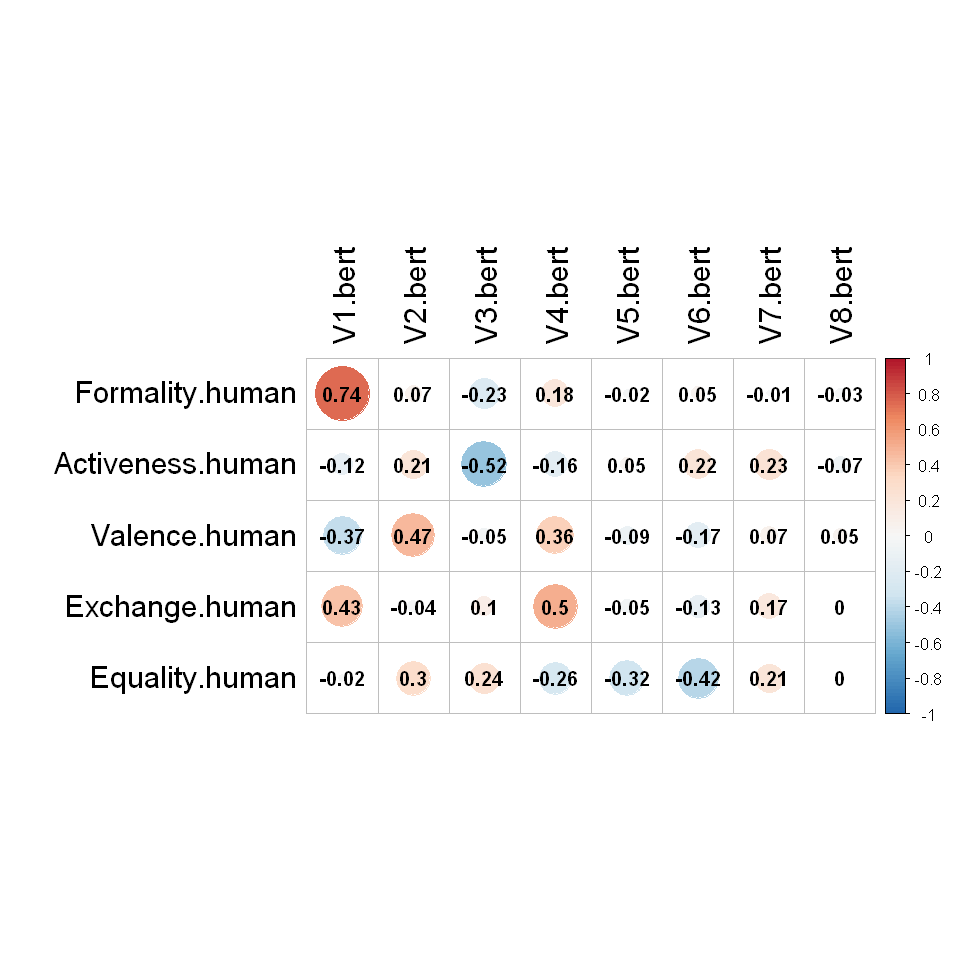

In [18]:
ncomp = 8
dim_rel.pca = prcomp(bert_768d)
loadings_none = dim_rel.pca$rotation[,1:ncomp]%*% diag(dim_rel.pca$sdev,ncomp,ncomp)
scores_none = dim_rel.pca$x[,1:ncomp] 

# pca with varimax rotation
loadings_var = data.frame(varimax(loadings_none)$loadings[,])
scores_var = scale(scores_none) %*% varimax(loadings_none)$rotmat

bert_scores = data.frame(scores_var)
colnames(bert_scores) = paste0('V',seq(1,ncomp),'.bert')

bert_human_combine = cbind(human_scores,bert_scores)
bert_human_cor = cor(bert_human_combine,method='spearman')

options(repr.plot.width=8, repr.plot.height=8)
corrplot(bert_human_cor[1:5,6:length(bert_human_combine)],is.corr=FALSE,
         addCoef.col = "black",
         tl.col="black",tl.cex=1.5,
         col.lim = c(-1,1),
         col = colorRampPalette(rev(brewer.pal(n=7,name ="RdBu")))(100))

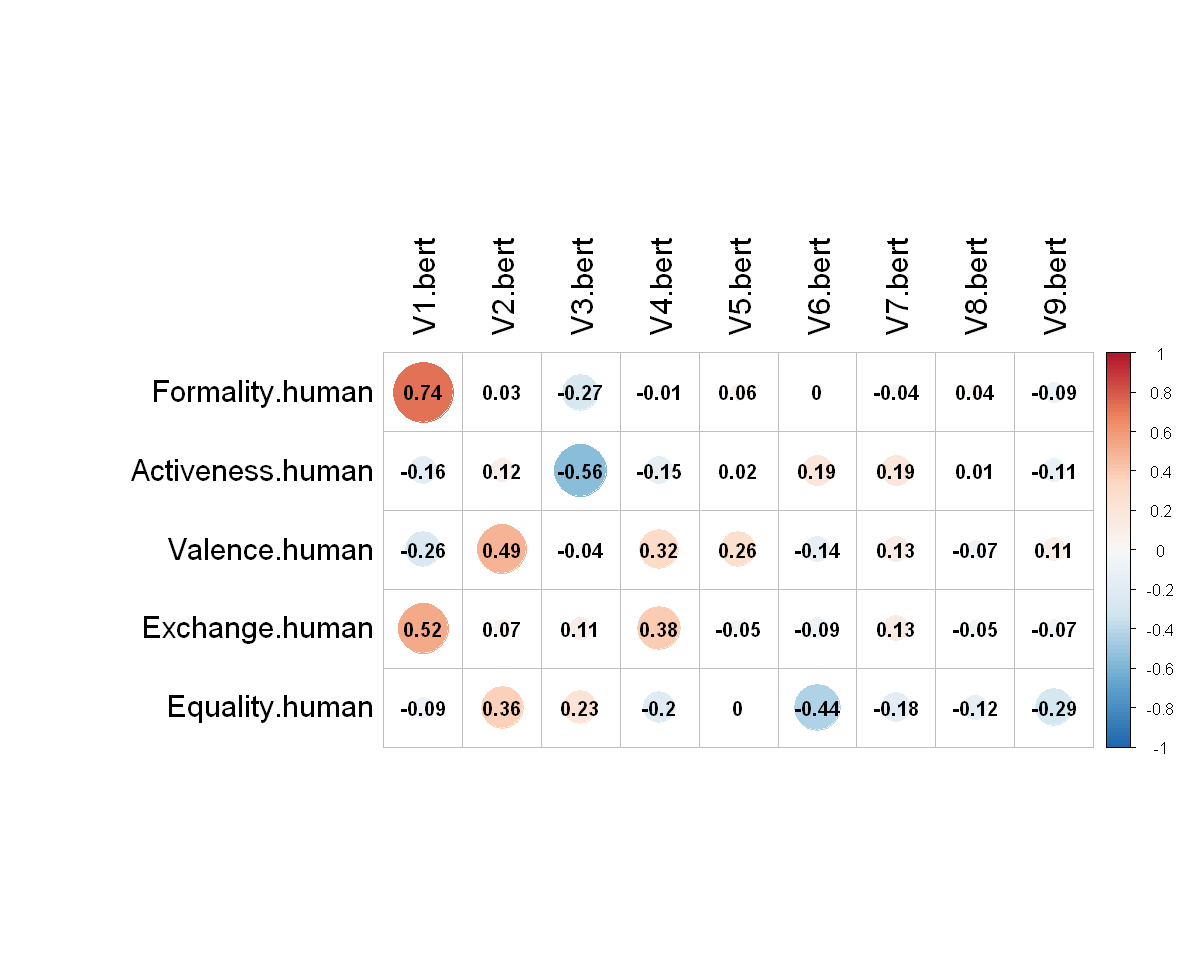

In [19]:
ncomp = 9
dim_rel.pca = prcomp(bert_768d)
loadings_none = dim_rel.pca$rotation[,1:ncomp]%*% diag(dim_rel.pca$sdev,ncomp,ncomp)
scores_none = dim_rel.pca$x[,1:ncomp] 

# pca with varimax rotation
loadings_var = data.frame(varimax(loadings_none)$loadings[,])
scores_var = scale(scores_none) %*% varimax(loadings_none)$rotmat

bert_scores = data.frame(scores_var)
colnames(bert_scores) = paste0('V',seq(1,ncomp),'.bert')

bert_human_combine = cbind(human_scores,bert_scores)
bert_human_cor = cor(bert_human_combine,method='spearman')

options(repr.plot.width=10, repr.plot.height=8)
corrplot(bert_human_cor[1:5,6:length(bert_human_combine)],is.corr=FALSE,
         addCoef.col = "black",
         tl.col="black",tl.cex=1.5,
         col.lim = c(-1,1),
         col = colorRampPalette(rev(brewer.pal(n=7,name ="RdBu")))(100))

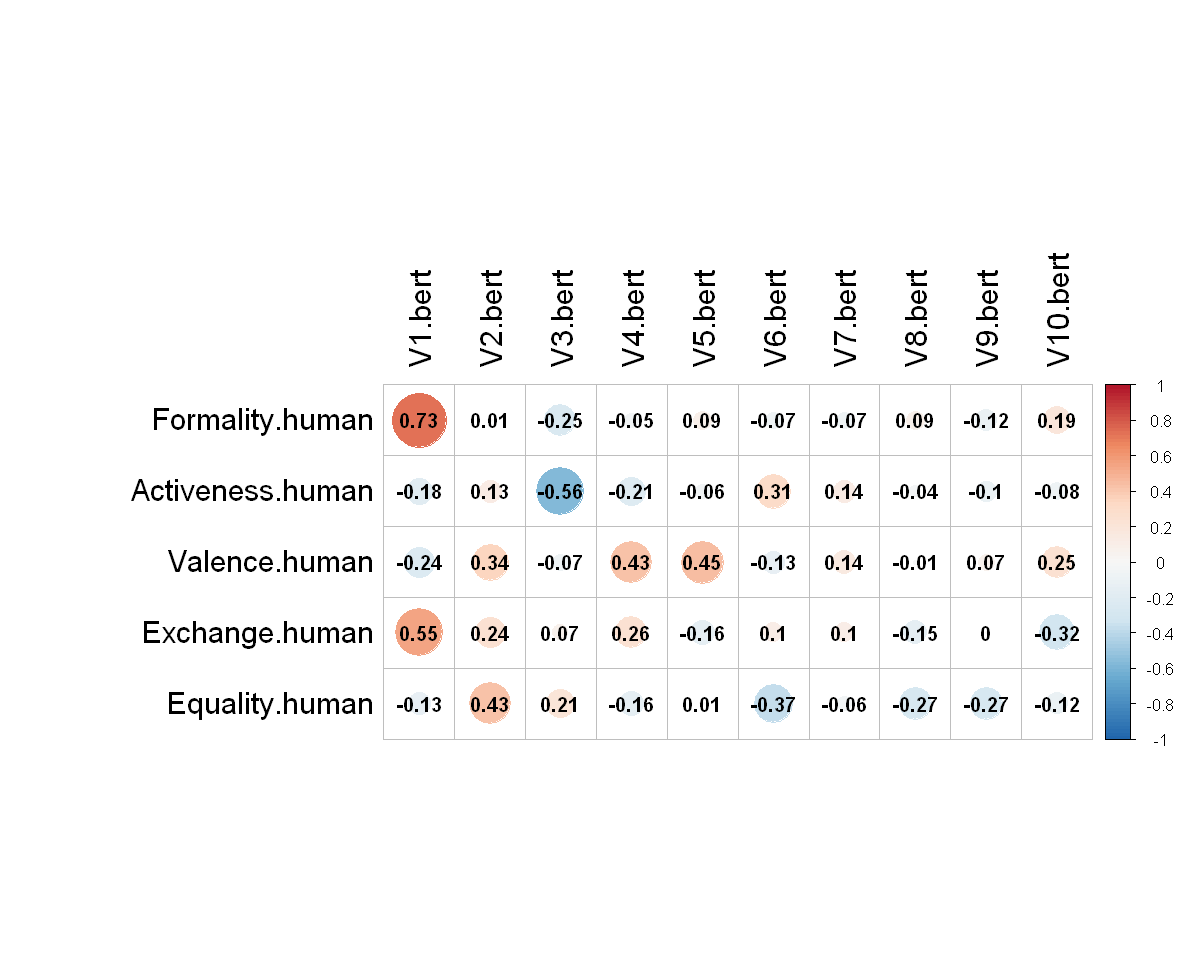

In [20]:
ncomp = 10
dim_rel.pca = prcomp(bert_768d)
loadings_none = dim_rel.pca$rotation[,1:ncomp]%*% diag(dim_rel.pca$sdev,ncomp,ncomp)
scores_none = dim_rel.pca$x[,1:ncomp] 

# pca with varimax rotation
loadings_var = data.frame(varimax(loadings_none)$loadings[,])
scores_var = scale(scores_none) %*% varimax(loadings_none)$rotmat

bert_scores = data.frame(scores_var)
colnames(bert_scores) = paste0('V',seq(1,ncomp),'.bert')

bert_human_combine = cbind(human_scores,bert_scores)
bert_human_cor = cor(bert_human_combine,method='spearman')

options(repr.plot.width=10, repr.plot.height=8)
corrplot(bert_human_cor[1:5,6:length(bert_human_combine)],is.corr=FALSE,
         addCoef.col = "black",
         tl.col="black",tl.cex=1.5,
         col.lim = c(-1,1),
         col = colorRampPalette(rev(brewer.pal(n=7,name ="RdBu")))(100))

In [172]:
brewer.pal(n=7,name ="RdBu")

[1] "#B2182B" "#EF8A62" "#FDDBC7" "#F7F7F7" "#D1E5F0" "#67A9CF" "#2166AC"

### 33 dimension

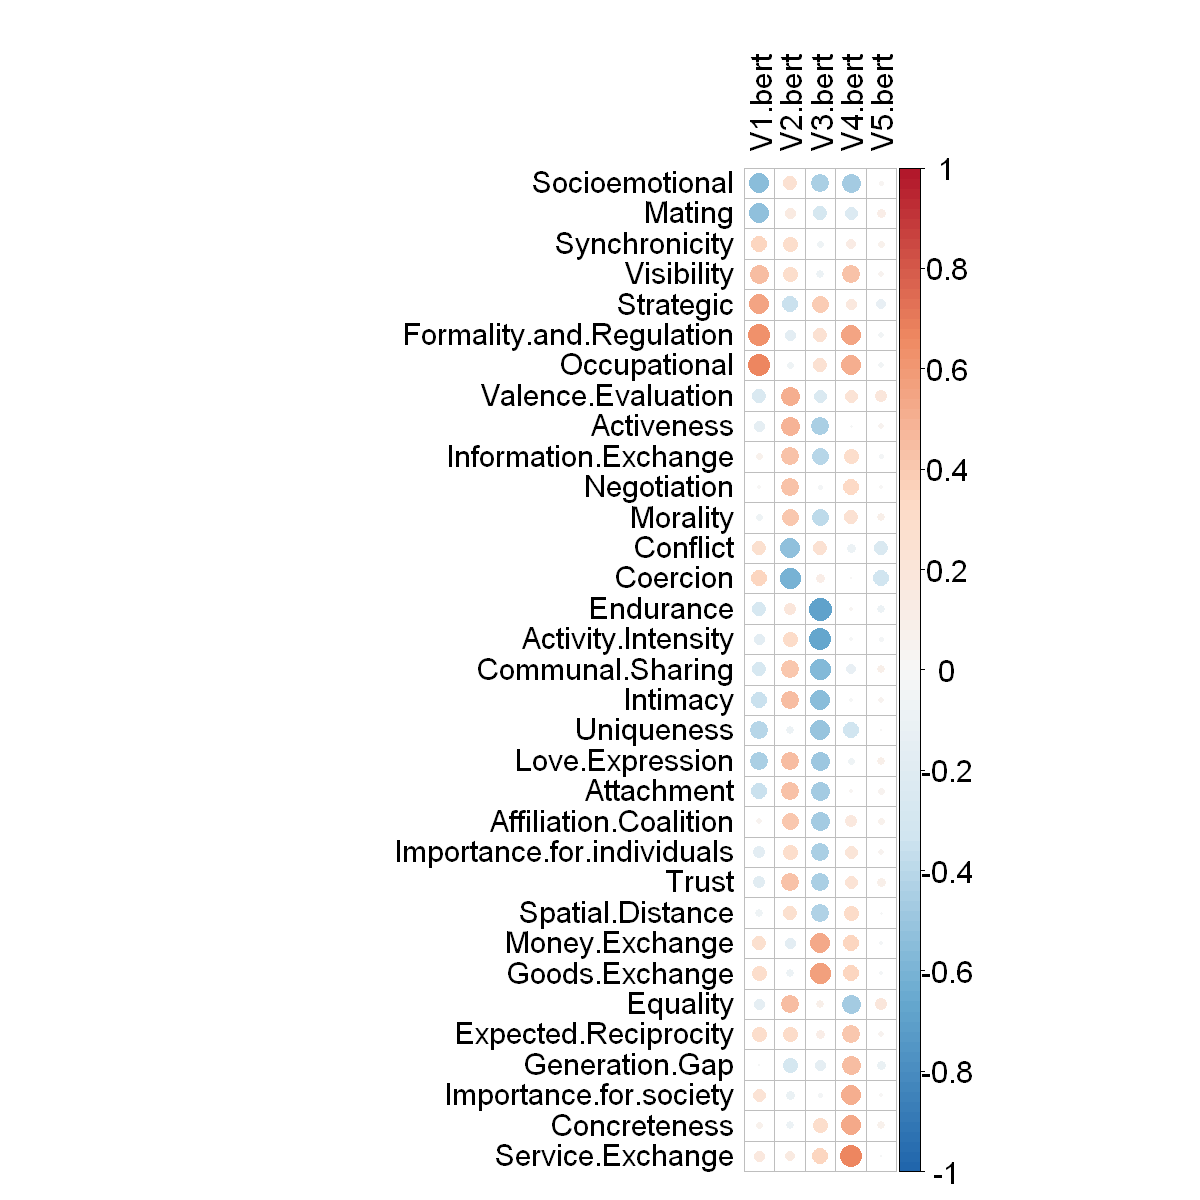

In [24]:
ncomp = 5
dim_rel.pca = prcomp(bert_768d)
loadings_none = dim_rel.pca$rotation[,1:ncomp]%*% diag(dim_rel.pca$sdev,ncomp,ncomp)
scores_none = dim_rel.pca$x[,1:ncomp] 

# pca with varimax rotation
loadings_var = data.frame(varimax(loadings_none)$loadings[,])
scores_var = scale(scores_none) %*% varimax(loadings_none)$rotmat

bert_scores = data.frame(scores_var)
colnames(bert_scores) = paste0('V',seq(1,ncomp),'.bert')

bert_human_combine = cbind(human_33d,bert_scores)
bert_human_cor = cor(bert_human_combine,method='spearman')
bert_loading = bert_human_cor[1:33,34:length(bert_human_combine)]
loadings_var_reorder = data.frame(bert_loading)

#filter each row's max loading, and attribute it to correspnding column.
order_list = c()
for (row in c(1:33)){
    temp_max = abs(loadings_var_reorder[row,1])
    n = 1
    for (col in c(2:5)){
        temp = abs(loadings_var_reorder[row,col])
        if (temp > temp_max){
            temp_max = temp
            n = col
        }
        
    }
    order_list[row] = n
}
loadings_var_reorder = loadings_var_reorder %>% mutate(order = order_list)
RC1 = loadings_var_reorder %>% filter(order==1) %>% arrange(V1.bert)
RC2 = loadings_var_reorder %>% filter(order==2) %>% arrange(desc(V2.bert))
RC3 = loadings_var_reorder %>% filter(order==3) %>% arrange(V3.bert)
RC4 = loadings_var_reorder %>% filter(order==4) %>% arrange(V4.bert)
RC5 = loadings_var_reorder %>% filter(order==5) %>% arrange(desc(V5.bert))

loadings_var_reorder = rbind(RC1,RC2,RC3,RC4,RC5)
loadings_var_reorder = loadings_var_reorder[1:5]

options(repr.plot.width=10, repr.plot.height=10)
corrplot(as.matrix(loadings_var_reorder),is.corr=FALSE,
         #addCoef.col = "black",
         tl.col="black",tl.cex=1.5,
         cl.ratio = 0.6,
         col.lim = c(-1,1),
         cl.cex = 1.5,
         col = colorRampPalette(rev(brewer.pal(n=7,name ="RdBu")))(100))

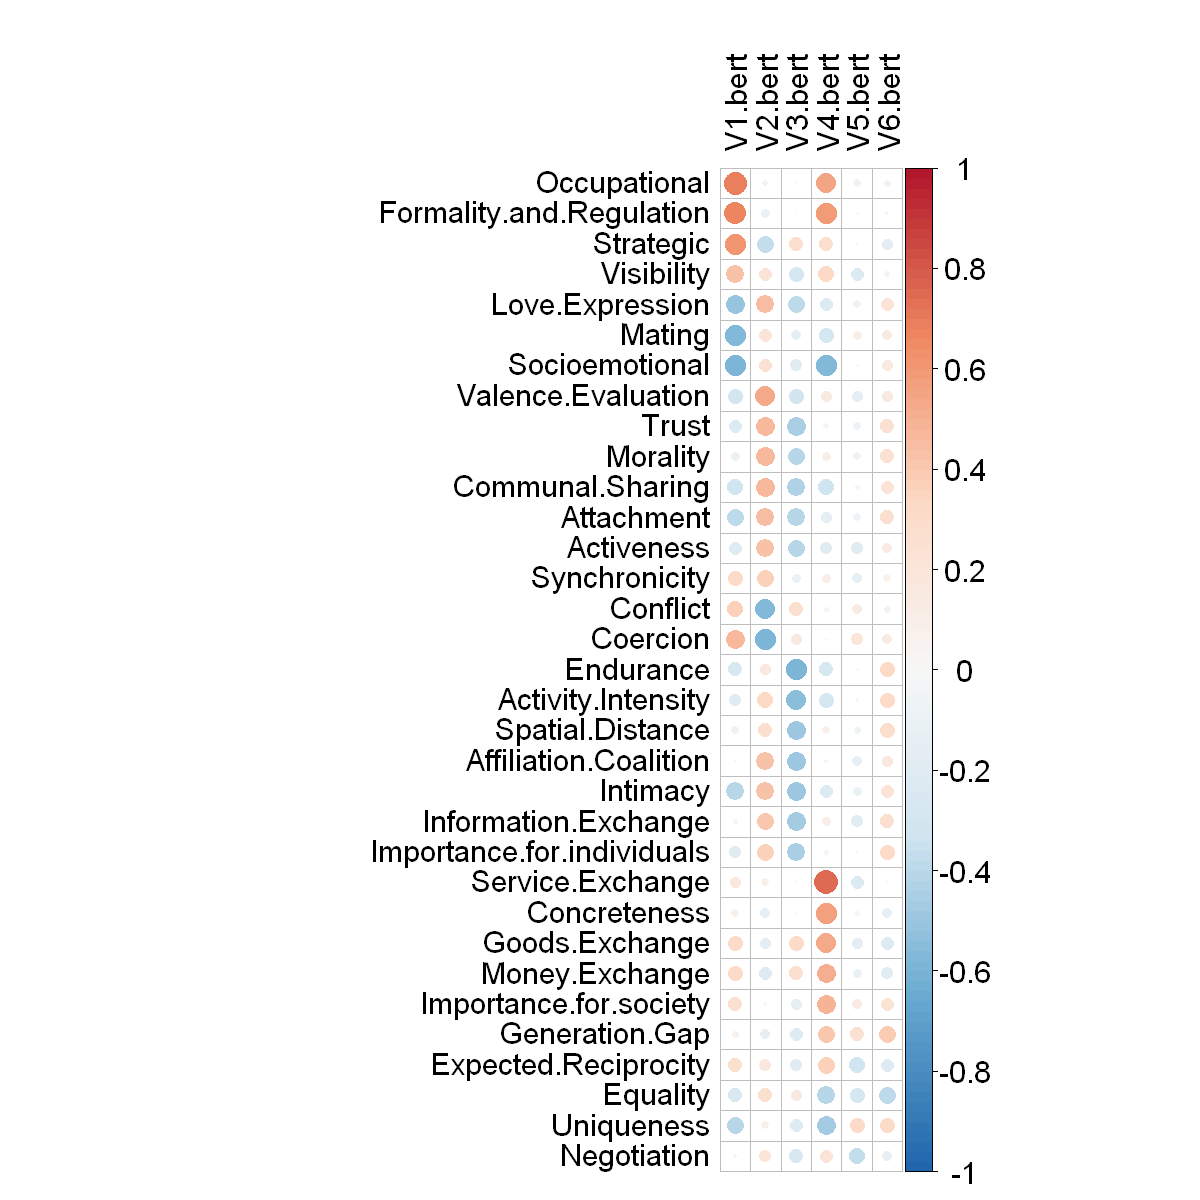

In [25]:
ncomp = 6
dim_rel.pca = prcomp(bert_768d)
loadings_none = dim_rel.pca$rotation[,1:ncomp]%*% diag(dim_rel.pca$sdev,ncomp,ncomp)
scores_none = dim_rel.pca$x[,1:ncomp] 

# pca with varimax rotation
loadings_var = data.frame(varimax(loadings_none)$loadings[,])
scores_var = scale(scores_none) %*% varimax(loadings_none)$rotmat

bert_scores = data.frame(scores_var)
colnames(bert_scores) = paste0('V',seq(1,ncomp),'.bert')

bert_human_combine = cbind(human_33d,bert_scores)
bert_human_cor = cor(bert_human_combine,method='spearman')
bert_loading = bert_human_cor[1:33,34:length(bert_human_combine)]
loadings_var_reorder = data.frame(bert_loading)

#filter each row's max loading, and attribute it to correspnding column.
order_list = c()
for (row in c(1:33)){
    temp_max = abs(loadings_var_reorder[row,1])
    n = 1
    for (col in c(2:6)){
        temp = abs(loadings_var_reorder[row,col])
        if (temp > temp_max){
            temp_max = temp
            n = col
        }
        
    }
    order_list[row] = n
}
loadings_var_reorder = loadings_var_reorder %>% mutate(order = order_list)
RC1 = loadings_var_reorder %>% filter(order==1) %>% arrange(desc(V1.bert))
RC2 = loadings_var_reorder %>% filter(order==2) %>% arrange(desc(V2.bert))
RC3 = loadings_var_reorder %>% filter(order==3) %>% arrange(V3.bert)
RC4 = loadings_var_reorder %>% filter(order==4) %>% arrange(desc(V4.bert))
RC5 = loadings_var_reorder %>% filter(order==5) %>% arrange(desc(V5.bert))
RC6 = loadings_var_reorder %>% filter(order==6) %>% arrange(desc(V6.bert))

loadings_var_reorder = rbind(RC1,RC2,RC3,RC4,RC5,RC6)
loadings_var_reorder = loadings_var_reorder[1:6]

options(repr.plot.width=10, repr.plot.height=10)
corrplot(as.matrix(loadings_var_reorder),is.corr=FALSE,
         #addCoef.col = "black",
         tl.col="black",tl.cex=1.5,
         cl.ratio = 0.6,
         col.lim = c(-1,1),
         cl.cex = 1.5,
         col = colorRampPalette(rev(brewer.pal(n=7,name ="RdBu")))(100))

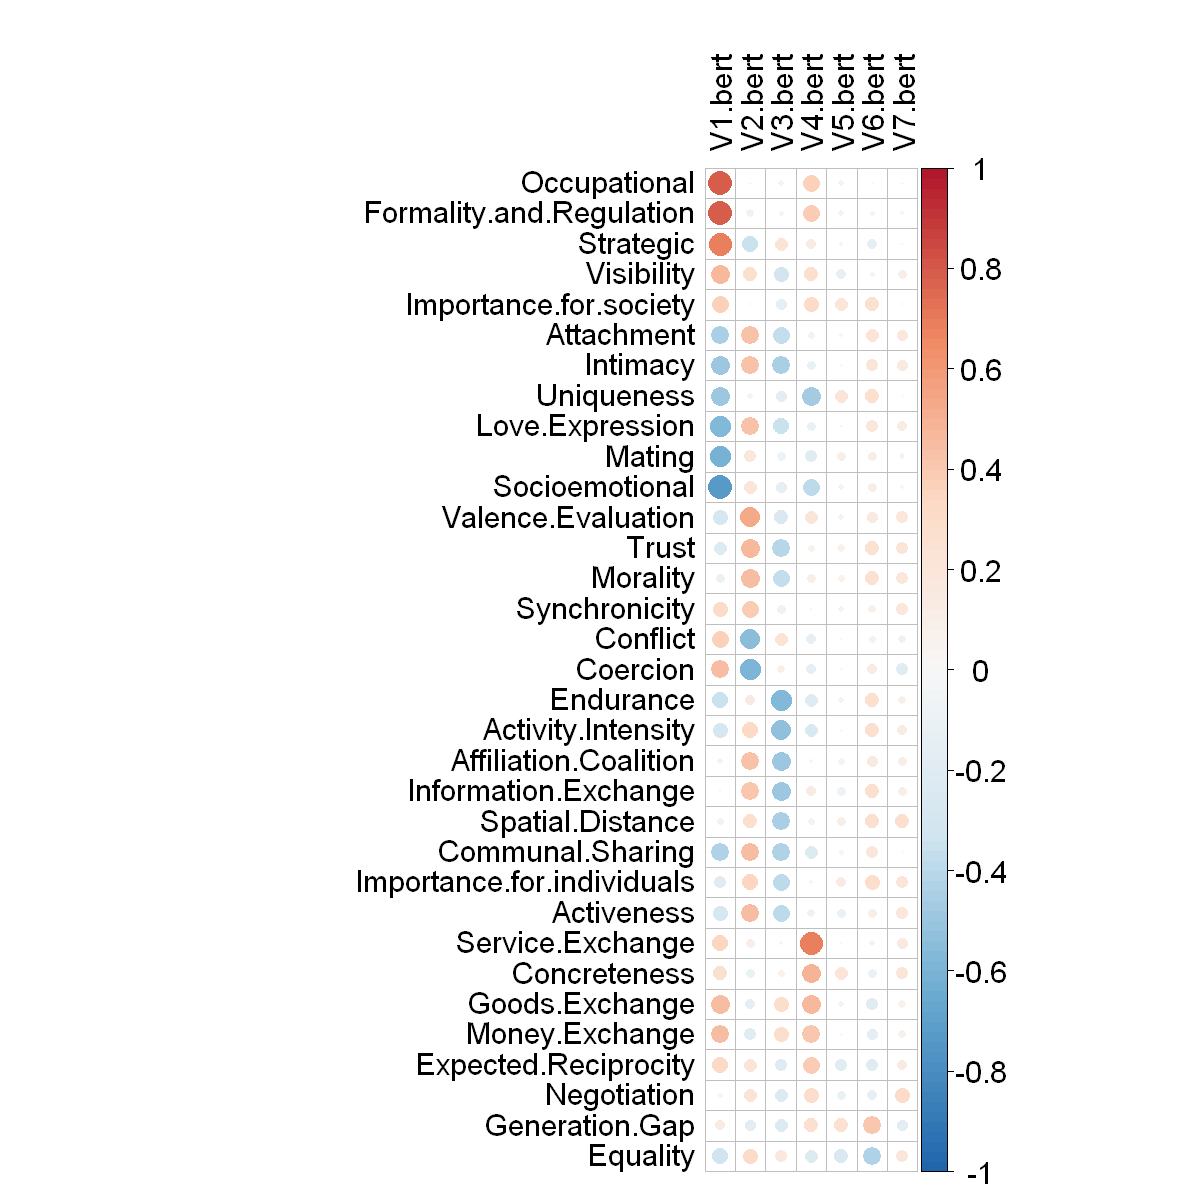

In [26]:
ncomp = 7
dim_rel.pca = prcomp(bert_768d)
loadings_none = dim_rel.pca$rotation[,1:ncomp]%*% diag(dim_rel.pca$sdev,ncomp,ncomp)
scores_none = dim_rel.pca$x[,1:ncomp] 

# pca with varimax rotation
loadings_var = data.frame(varimax(loadings_none)$loadings[,])
scores_var = scale(scores_none) %*% varimax(loadings_none)$rotmat

bert_scores = data.frame(scores_var)
colnames(bert_scores) = paste0('V',seq(1,ncomp),'.bert')

bert_human_combine = cbind(human_33d,bert_scores)
bert_human_cor = cor(bert_human_combine,method='spearman')
bert_loading = bert_human_cor[1:33,34:length(bert_human_combine)]
loadings_var_reorder = data.frame(bert_loading)

#filter each row's max loading, and attribute it to correspnding column.
order_list = c()
for (row in c(1:33)){
    temp_max = abs(loadings_var_reorder[row,1])
    n = 1
    for (col in c(2:7)){
        temp = abs(loadings_var_reorder[row,col])
        if (temp > temp_max){
            temp_max = temp
            n = col
        }
        
    }
    order_list[row] = n
}
loadings_var_reorder = loadings_var_reorder %>% mutate(order = order_list)
loadings_var_reorder['Negotiation','order'] = 5
loadings_var_reorder['Activeness','order'] = 3
loadings_var_reorder['Communal.Sharing','order'] = 3
loadings_var_reorder['Money.Exchange','order'] = 4
RC1 = loadings_var_reorder %>% filter(order==1) %>% arrange(desc(V1.bert))
RC2 = loadings_var_reorder %>% filter(order==2) %>% arrange(desc(V2.bert))
RC3 = loadings_var_reorder %>% filter(order==3) %>% arrange(V3.bert)
RC4 = loadings_var_reorder %>% filter(order==4) %>% arrange(desc(V4.bert))
RC5 = loadings_var_reorder %>% filter(order==5) %>% arrange(desc(V5.bert))
RC6 = loadings_var_reorder %>% filter(order==6) %>% arrange(desc(V6.bert))
RC7 = loadings_var_reorder %>% filter(order==7) %>% arrange(V7.bert)

loadings_var_reorder = rbind(RC1,RC2,RC3,RC4,RC5,RC6,RC7)
loadings_var_reorder = loadings_var_reorder[1:7]

options(repr.plot.width=10, repr.plot.height=10)
corrplot(as.matrix(loadings_var_reorder),is.corr=FALSE,
         #addCoef.col = "black",
         tl.col="black",tl.cex=1.5,
         cl.ratio = 0.5,
         col.lim = c(-1,1),
         cl.cex = 1.5,
         col = colorRampPalette(rev(brewer.pal(n=7,name ="RdBu")))(100))

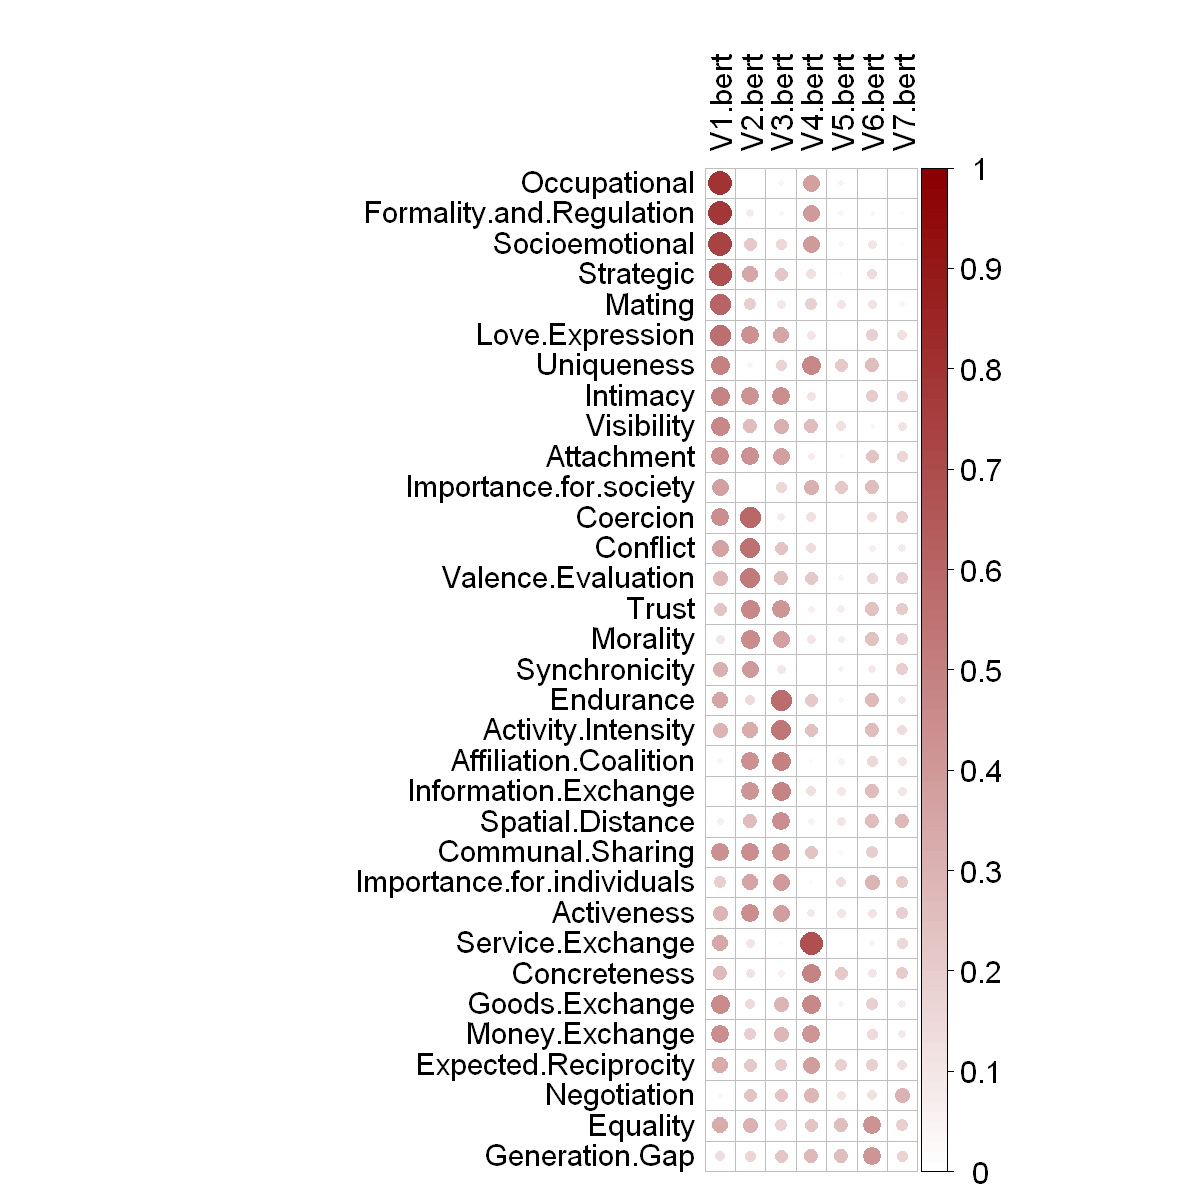

In [28]:
ncomp = 7
dim_rel.pca = prcomp(bert_768d)
loadings_none = dim_rel.pca$rotation[,1:ncomp]%*% diag(dim_rel.pca$sdev,ncomp,ncomp)
scores_none = dim_rel.pca$x[,1:ncomp] 

# pca with varimax rotation
loadings_var = data.frame(varimax(loadings_none)$loadings[,])
scores_var = scale(scores_none) %*% varimax(loadings_none)$rotmat

bert_scores = data.frame(scores_var)
colnames(bert_scores) = paste0('V',seq(1,ncomp),'.bert')

bert_human_combine = cbind(human_33d,bert_scores)
bert_human_cor = cor(bert_human_combine,method='spearman')
bert_loading = bert_human_cor[1:33,34:length(bert_human_combine)]
loadings_var_reorder = data.frame(bert_loading)

#filter each row's max loading, and attribute it to correspnding column.
order_list = c()
for (row in c(1:33)){
    temp_max = abs(loadings_var_reorder[row,1])
    n = 1
    for (col in c(2:7)){
        temp = abs(loadings_var_reorder[row,col])
        if (temp > temp_max){
            temp_max = temp
            n = col
        }
        
    }
    order_list[row] = n
}
loadings_var_reorder = abs(loadings_var_reorder) %>% mutate(order = order_list)
loadings_var_reorder['Negotiation','order'] = 5
loadings_var_reorder['Activeness','order'] = 3
loadings_var_reorder['Communal.Sharing','order'] = 3
loadings_var_reorder['Money.Exchange','order'] = 4
RC1 = loadings_var_reorder %>% filter(order==1) %>% arrange(desc(V1.bert))
RC2 = loadings_var_reorder %>% filter(order==2) %>% arrange(desc(V2.bert))
RC3 = loadings_var_reorder %>% filter(order==3) %>% arrange(desc(V3.bert))
RC4 = loadings_var_reorder %>% filter(order==4) %>% arrange(desc(V4.bert))
RC5 = loadings_var_reorder %>% filter(order==5) %>% arrange(V5.bert)
RC6 = loadings_var_reorder %>% filter(order==6) %>% arrange(desc(V6.bert))
RC7 = loadings_var_reorder %>% filter(order==7) %>% arrange(V7.bert)

loadings_var_reorder = rbind(RC1,RC2,RC3,RC4,RC5,RC6,RC7)
loadings_var_reorder = loadings_var_reorder[1:7]

options(repr.plot.width=10, repr.plot.height=10)
corrplot(as.matrix(loadings_var_reorder),is.corr=FALSE,
         #addCoef.col = "black",
         tl.col="black",tl.cex=1.5,
         cl.ratio = 0.5,
         col.lim = c(0,1),
         cl.cex = 1.5,
         col = colorRampPalette(c("white","darkred"))(100))

In [29]:
png("output_graph/modern_PCA_loading_abs.png", bg="transparent",
    family = 'sans',units='in',width=10,height=10,res=300)
options(repr.plot.width=10, repr.plot.height=10)
corrplot(as.matrix(loadings_var_reorder),is.corr=FALSE,
         #addCoef.col = "black",
         tl.col="black",tl.cex=1.5,
         cl.ratio = 0.5,
         col.lim = c(0,1),
         cl.cex = 1.5,
         col = colorRampPalette(c("white","darkred"))(100))
dev.off()

png 
  2

***

## Ancient

In [24]:
bert_768d_ancient=read.csv('bert_embedding_data/ancient/q3.2_bert_embedding_data/MASK_embedding_output.csv',
                   row.names = 1, check.names = FALSE, fileEncoding = 'gb18030')

prompt_rels_map = read.csv('human_rating_data/ancient_modern_map_120r.csv',row.names=1,check.names=FALSE, fileEncoding = 'gb18030')
name_mapping <- setNames(prompt_rels_map$'对应的现代人际关系', # new name
                         prompt_rels_map$'query') # old name
bert_768d_ancient = bert_768d_ancient[bert_768d_ancient$'word' %in% prompt_rels_map$'query',]
bert_768d_ancient$'word' = prompt_rels_map$'对应的现代人际关系'
rownames(bert_768d_ancient) = bert_768d_ancient$'word'
bert_768d_ancient = bert_768d_ancient[,-c(1)]
bert_768d_ancient = scaleN(bert_768d_ancient)
rels_ancient_order = rownames(bert_768d_ancient)

dim(bert_768d_ancient)
human_scores_ancient = human_scores[rels_ancient_order,]
human_33d_ancient = human_33d[rels_ancient_order,]

human_sim_ancient = human_sim[rels_ancient_order,rels_ancient_order]
human_sim_ancient_array = lowerTriangle(human_sim_ancient)
bert_768d_ancient_sim = cosine_matrix(bert_768d_ancient)
cor(human_sim_ancient_array,lowerTriangle(bert_768d_ancient_sim), method = 'spearman')

[1] 120 768

[1] 0.4310078

### FAVEE

Warning message in corrplot(bert_human_cor[1:5, 6:length(bert_human_combine)], is.corr = FALSE, :
"col.lim interval too wide, please set a suitable value"


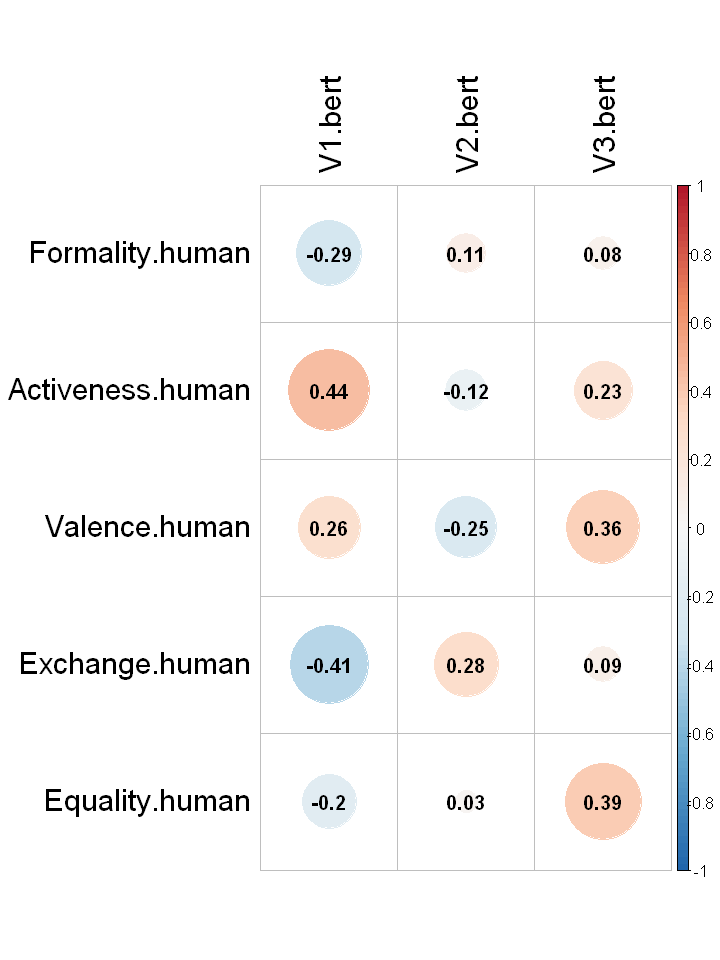

In [25]:
ncomp = 3
dim_rel.pca = prcomp(bert_768d_ancient)
loadings_none = dim_rel.pca$rotation[,1:ncomp]%*% diag(dim_rel.pca$sdev,ncomp,ncomp)
scores_none = dim_rel.pca$x[,1:ncomp] 

# pca with varimax rotation
loadings_var = data.frame(varimax(loadings_none)$loadings[,])
scores_var = scale(scores_none) %*% varimax(loadings_none)$rotmat

bert_scores = data.frame(scores_var)
colnames(bert_scores) = paste0('V',seq(1,ncomp),'.bert')

bert_human_combine = cbind(human_scores_ancient,bert_scores)
bert_human_cor = cor(bert_human_combine,method='spearman')

options(repr.plot.width=6, repr.plot.height=8)
corrplot(bert_human_cor[1:5,6:length(bert_human_combine)],is.corr=FALSE,
         addCoef.col = "black",
         tl.col="black",tl.cex=1.5,
         col.lim = c(-1,1),
         col = colorRampPalette(rev(brewer.pal(n=7,name ="RdBu")))(100))

Warning message in corrplot(bert_human_cor[1:5, 6:length(bert_human_combine)], is.corr = FALSE, :
"col.lim interval too wide, please set a suitable value"


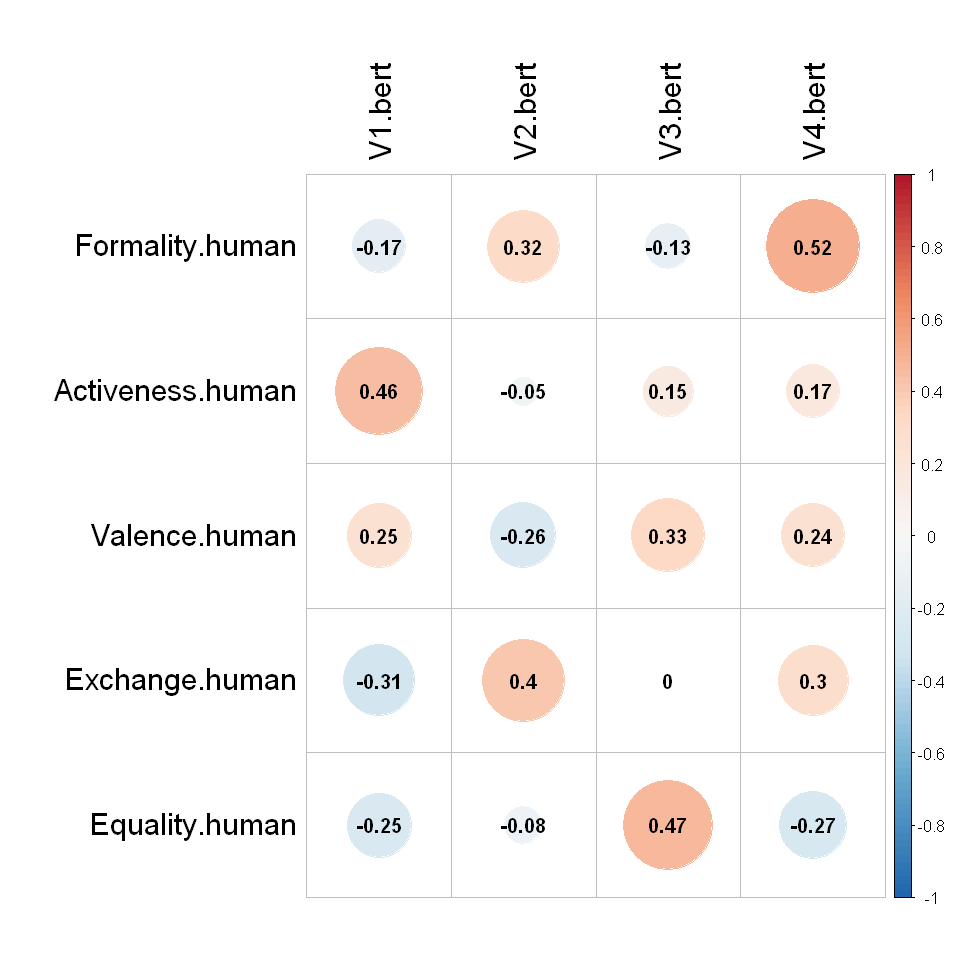

In [26]:
ncomp = 4
dim_rel.pca = prcomp(bert_768d_ancient)
loadings_none = dim_rel.pca$rotation[,1:ncomp]%*% diag(dim_rel.pca$sdev,ncomp,ncomp)
scores_none = dim_rel.pca$x[,1:ncomp] 

# pca with varimax rotation
loadings_var = data.frame(varimax(loadings_none)$loadings[,])
scores_var = scale(scores_none) %*% varimax(loadings_none)$rotmat

bert_scores = data.frame(scores_var)
colnames(bert_scores) = paste0('V',seq(1,ncomp),'.bert')

bert_human_combine = cbind(human_scores_ancient,bert_scores)
bert_human_cor = cor(bert_human_combine,method='spearman')

options(repr.plot.width=8, repr.plot.height=8)
corrplot(bert_human_cor[1:5,6:length(bert_human_combine)],is.corr=FALSE,
         addCoef.col = "black",
         tl.col="black",tl.cex=1.5,
         col.lim = c(-1,1),
         col = colorRampPalette(rev(brewer.pal(n=7,name ="RdBu")))(100))

Warning message in corrplot(bert_human_cor[1:5, 6:length(bert_human_combine)], is.corr = FALSE, :
"col.lim interval too wide, please set a suitable value"


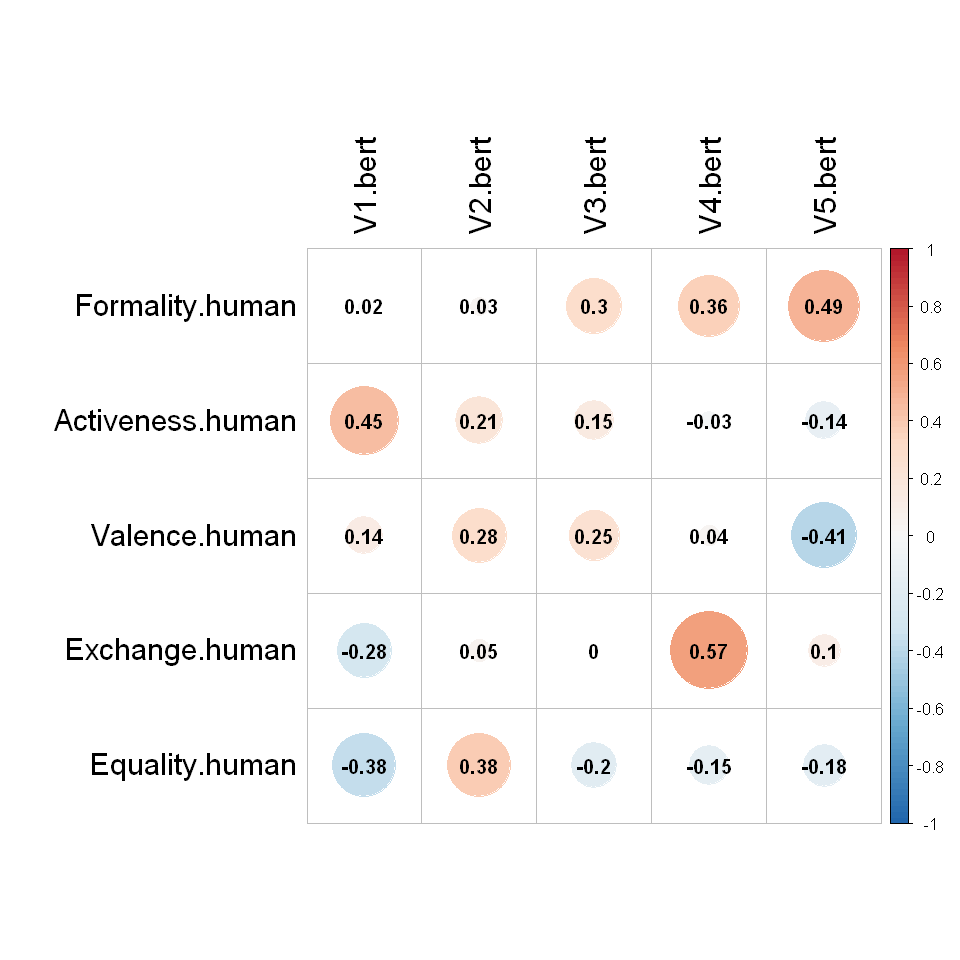

In [27]:
ncomp = 5
dim_rel.pca = prcomp(bert_768d_ancient)
loadings_none = dim_rel.pca$rotation[,1:ncomp]%*% diag(dim_rel.pca$sdev,ncomp,ncomp)
scores_none = dim_rel.pca$x[,1:ncomp] 

# pca with varimax rotation
loadings_var = data.frame(varimax(loadings_none)$loadings[,])
scores_var = scale(scores_none) %*% varimax(loadings_none)$rotmat

bert_scores = data.frame(scores_var)
colnames(bert_scores) = paste0('V',seq(1,ncomp),'.bert')

bert_human_combine = cbind(human_scores_ancient,bert_scores)
bert_human_cor = cor(bert_human_combine,method='spearman')

options(repr.plot.width=8, repr.plot.height=8)
corrplot(bert_human_cor[1:5,6:length(bert_human_combine)],is.corr=FALSE,
         addCoef.col = "black",
         tl.col="black",tl.cex=1.5,
         col.lim = c(-1,1),
         col = colorRampPalette(rev(brewer.pal(n=7,name ="RdBu")))(100))

Warning message in corrplot(bert_human_cor[1:5, 6:length(bert_human_combine)], is.corr = FALSE, :
"col.lim interval too wide, please set a suitable value"


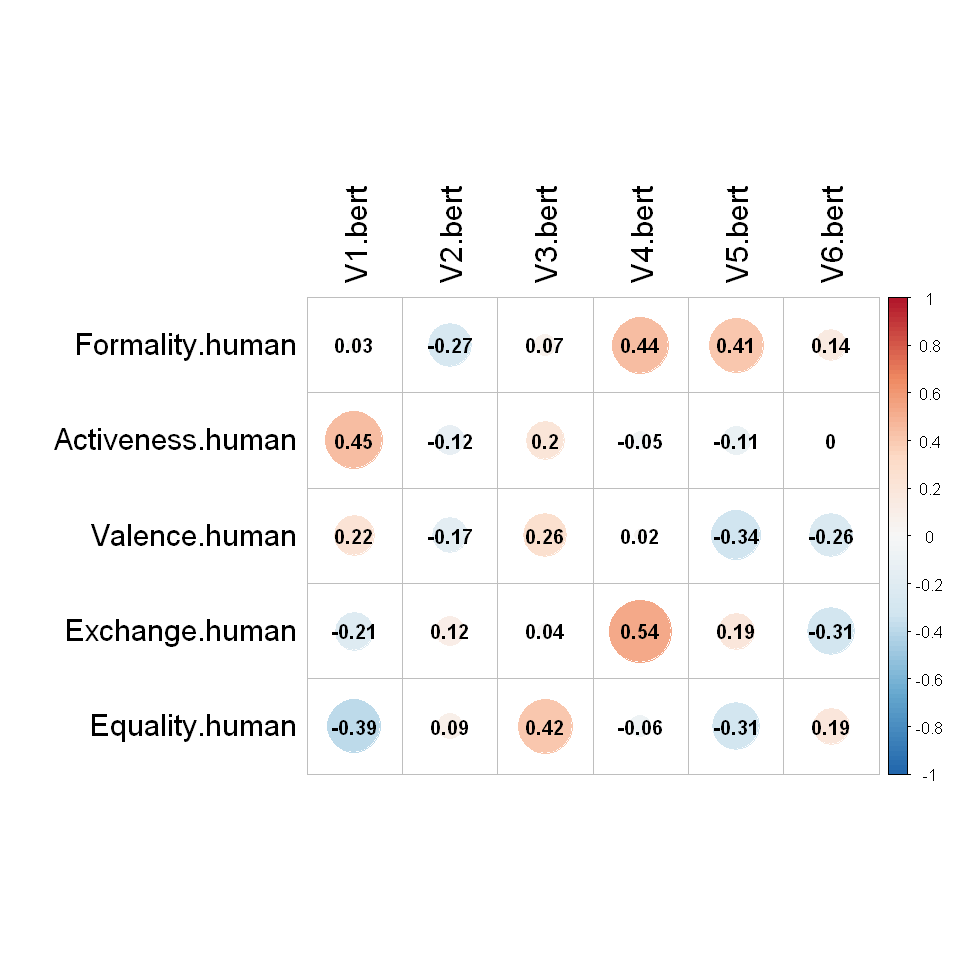

In [28]:
ncomp = 6
dim_rel.pca = prcomp(bert_768d_ancient)
loadings_none = dim_rel.pca$rotation[,1:ncomp]%*% diag(dim_rel.pca$sdev,ncomp,ncomp)
scores_none = dim_rel.pca$x[,1:ncomp] 

# pca with varimax rotation
loadings_var = data.frame(varimax(loadings_none)$loadings[,])
scores_var = scale(scores_none) %*% varimax(loadings_none)$rotmat

bert_scores = data.frame(scores_var)
colnames(bert_scores) = paste0('V',seq(1,ncomp),'.bert')

bert_human_combine = cbind(human_scores_ancient,bert_scores)
bert_human_cor = cor(bert_human_combine,method='spearman')

options(repr.plot.width=8, repr.plot.height=8)
corrplot(bert_human_cor[1:5,6:length(bert_human_combine)],is.corr=FALSE,
         addCoef.col = "black",
         tl.col="black",tl.cex=1.5,
         col.lim = c(-1,1),
         col = colorRampPalette(rev(brewer.pal(n=7,name ="RdBu")))(100))

Warning message in corrplot(bert_human_cor[1:5, 6:length(bert_human_combine)], is.corr = FALSE, :
"col.lim interval too wide, please set a suitable value"


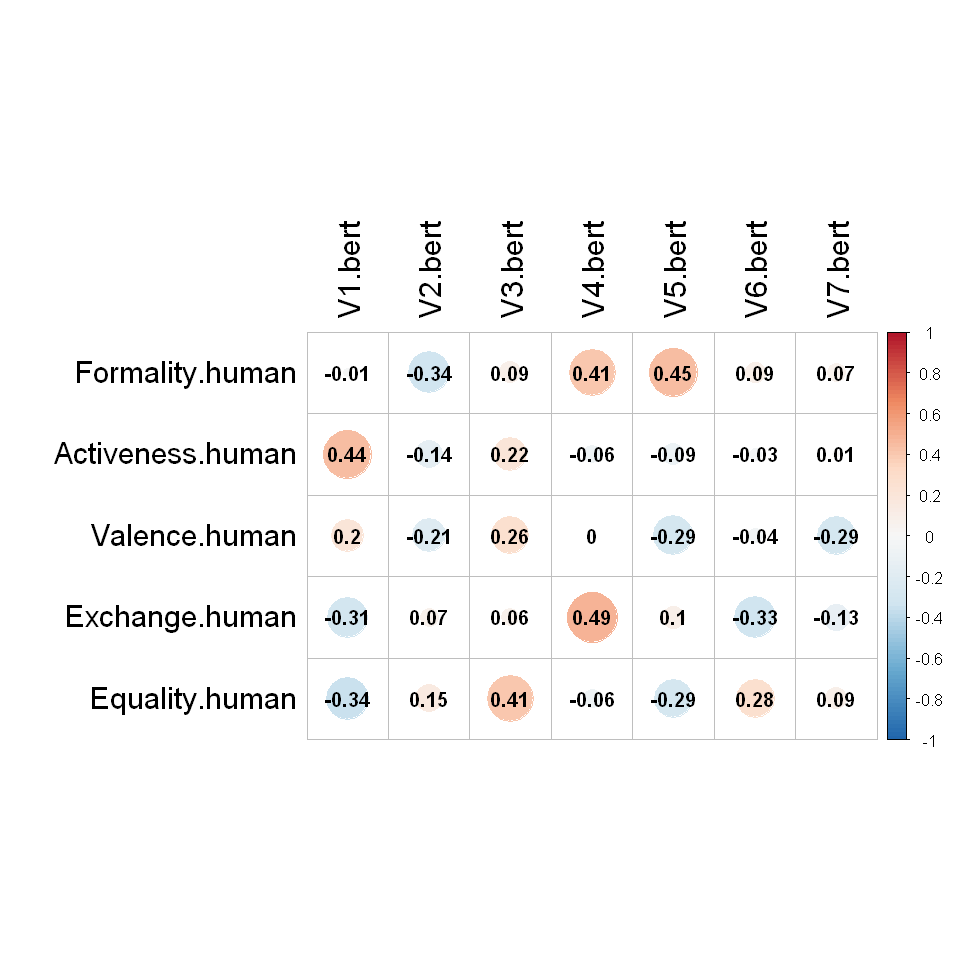

In [29]:
ncomp = 7
dim_rel.pca = prcomp(bert_768d_ancient)
loadings_none = dim_rel.pca$rotation[,1:ncomp]%*% diag(dim_rel.pca$sdev,ncomp,ncomp)
scores_none = dim_rel.pca$x[,1:ncomp] 

# pca with varimax rotation
loadings_var = data.frame(varimax(loadings_none)$loadings[,])
scores_var = scale(scores_none) %*% varimax(loadings_none)$rotmat

bert_scores = data.frame(scores_var)
colnames(bert_scores) = paste0('V',seq(1,ncomp),'.bert')

bert_human_combine = cbind(human_scores_ancient,bert_scores)
bert_human_cor = cor(bert_human_combine,method='spearman')
bert_scores_ancient = bert_scores

options(repr.plot.width=8, repr.plot.height=8)
corrplot(bert_human_cor[1:5,6:length(bert_human_combine)],is.corr=FALSE,
         addCoef.col = "black",
         tl.col="black",tl.cex=1.5,
         col.lim = c(-1,1),
         col = colorRampPalette(rev(brewer.pal(n=7,name ="RdBu")))(100))

Warning message in corrplot(plot_scores_ancient, is.corr = FALSE, addCoef.col = "black", :
"col.lim interval too wide, please set a suitable value"



	Spearman's rank correlation rho

data:  human_scores_ancient$Formality.human and bert_scores$V5.bert
S = 158206, p-value = 3.294e-07
alternative hypothesis: true rho is not equal to 0
sample estimates:
      rho 
0.4506355 



	Spearman's rank correlation rho

data:  human_scores_ancient$Activeness.human and bert_scores$V1.bert
S = 160352, p-value = 5.345e-07
alternative hypothesis: true rho is not equal to 0
sample estimates:
      rho 
0.4431836 



	Spearman's rank correlation rho

data:  human_scores_ancient$Valence.human and bert_scores$V7.bert
S = 370676, p-value = 0.001533
alternative hypothesis: true rho is not equal to 0
sample estimates:
       rho 
-0.2871588 



	Spearman's rank correlation rho

data:  human_scores_ancient$Exchange.human and bert_scores$V4.bert
S = 146066, p-value = 1.692e-08
alternative hypothesis: true rho is not equal to 0
sample estimates:
      rho 
0.4927912 



	Spearman's rank correlation rho

data:  human_scores_ancient$Equality.human and bert_scores$V3.bert
S = 171034, p-value = 5.094e-06
alternative hypothesis: true rho is not equal to 0
sample estimates:
      rho 
0.4060907 


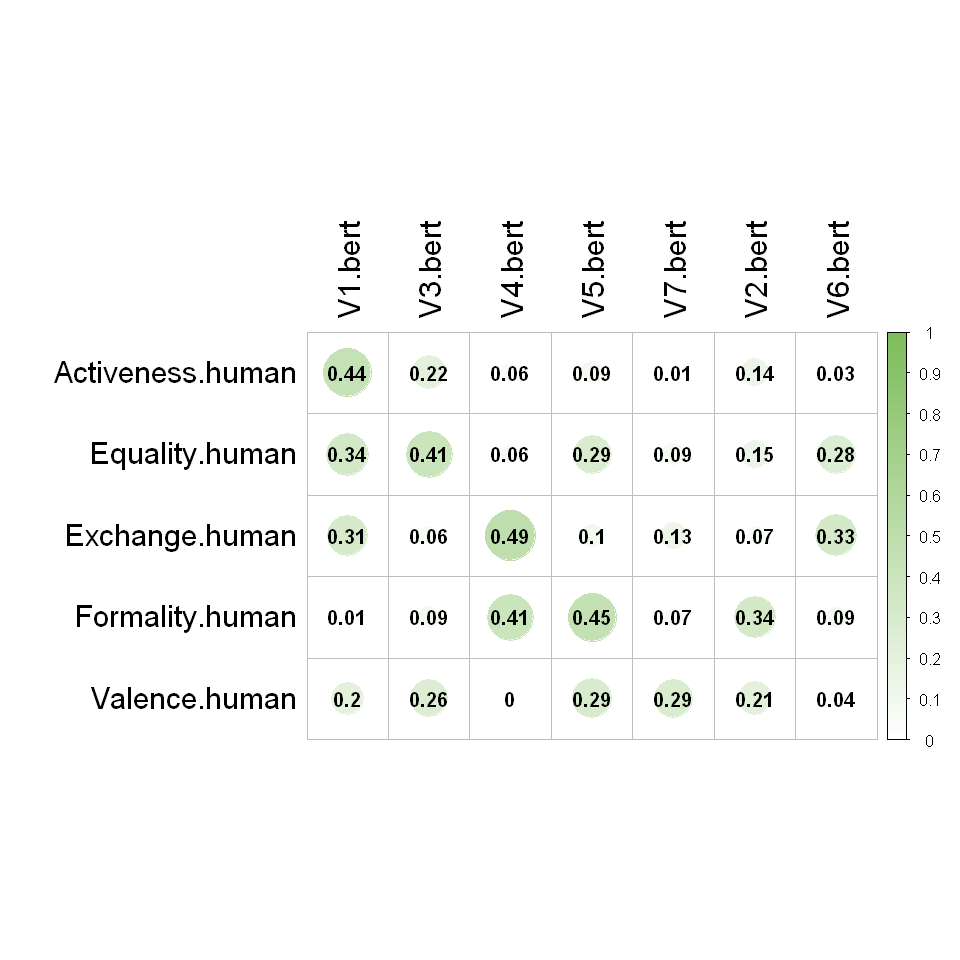

In [32]:
ncomp = 7
dim_rel.pca = prcomp(bert_768d_ancient)
loadings_none = dim_rel.pca$rotation[,1:ncomp]%*% diag(dim_rel.pca$sdev,ncomp,ncomp)
scores_none = dim_rel.pca$x[,1:ncomp] 

# pca with varimax rotation
loadings_var = data.frame(varimax(loadings_none)$loadings[,])
scores_var = scale(scores_none) %*% varimax(loadings_none)$rotmat

bert_scores = data.frame(scores_var)
colnames(bert_scores) = paste0('V',seq(1,ncomp),'.bert')

bert_human_combine = cbind(human_scores_ancient,bert_scores)
bert_human_cor = cor(bert_human_combine,method='spearman')
bert_scores_ancient = bert_scores

options(repr.plot.width=8, repr.plot.height=8)
plot_scores_ancient = abs(bert_human_cor[1:5,6:length(bert_human_combine)])
plot_scores_ancient = plot_scores_ancient[
              paste0(c('Activeness','Equality','Exchange','Formality','Valence'),'.human'),
                      paste0('V',c(1,3,4,5,7,2,6),'.bert')]
corrplot(plot_scores_ancient,is.corr=FALSE,
         addCoef.col = "black",
         tl.col="black",tl.cex=1.5,
         col.lim = c(0,1),
        col = colorRampPalette(c("white","#7EBD5B"))(100))

cor.test(human_scores_ancient$'Formality.human',bert_scores$'V5.bert',method='spearman')
cor.test(human_scores_ancient$'Activeness.human',bert_scores$'V1.bert',method='spearman')
cor.test(human_scores_ancient$'Valence.human',bert_scores$'V7.bert',method='spearman')
cor.test(human_scores_ancient$'Exchange.human',bert_scores$'V4.bert',method='spearman')
cor.test(human_scores_ancient$'Equality.human',bert_scores$'V3.bert',method='spearman')

In [14]:
plot_scores_ancient

,V1.bert,V3.bert,V4.bert,V5.bert,V7.bert,V2.bert,V6.bert
Activeness.human,0.44318355,0.21566775,0.062129315,0.09107577,0.01203556,0.14309327,0.03273144
Equality.human,0.34105841,0.40609070,0.064261407,0.28617265,0.08698521,0.14986457,0.27961664
Exchange.human,0.31118133,0.06065699,0.492791166,0.09975693,0.13468296,0.06631711,0.33123134
Formality.human,0.01350094,0.08787416,0.408285298,0.45063546,0.06659490,0.33541913,0.08593652
Valence.human,0.20257657,0.26180985,0.003132162,0.29486075,0.28715883,0.21336898,0.04113480


In [38]:
png("output_graph/Ancient_PCA_cor.png", bg="transparent",
    family = 'sans',units='in',width=8,height=8,res=300)

options(repr.plot.width=8, repr.plot.height=8)
plot_scores_ancient = abs(bert_human_cor[1:5,6:length(bert_human_combine)])
plot_scores_ancient = plot_scores_ancient[
              paste0(c('Activeness','Equality','Exchange','Formality','Valence'),'.human'),
                      paste0('V',c(1,3,4,5,7,2,6),'.bert')]
corrplot(plot_scores_ancient,is.corr=FALSE,
         #addCoef.col = "black",
         tl.col="black",tl.cex=1.5,
         col.lim = c(0,1),
        col = colorRampPalette(c("white","#7EBD5B"))(100))
dev.off()

Warning message in corrplot(plot_scores_ancient, is.corr = FALSE, tl.col = "black", :
"col.lim interval too wide, please set a suitable value"


png 
  2

In [39]:
# bert_formality_dist = c(dist(bert_scores_ancient['V5.bert']))
# cor(lowerTriangle(bert_768d_ancient_sim),-bert_formality_dist,method='spearman')

# bert_valence_dist = c(dist(bert_scores_ancient['V7.bert']))
# cor(lowerTriangle(bert_768d_ancient_sim),-bert_valence_dist,method='spearman')

# bert_activeness_dist = c(dist(bert_scores_ancient['V1.bert']))
# cor(lowerTriangle(bert_768d_ancient_sim),-bert_activeness_dist,method='spearman')

# bert_exchange_dist = c(dist(bert_scores_ancient['V4.bert']))
# cor(lowerTriangle(bert_768d_ancient_sim),-bert_exchange_dist,method='spearman')

# bert_equality_dist = c(dist(bert_scores_ancient['V3.bert']))
# cor(lowerTriangle(bert_768d_ancient_sim),-bert_equality_dist,method='spearman')

# within_cor = cbind(-bert_formality_dist,-bert_activeness_dist,
#                    -bert_valence_dist,-bert_exchange_dist,-bert_equality_dist,
#                    lowerTriangle(bert_768d_ancient_sim))
# colnames(within_cor) = c('Formaliy','Activeness','Valence','Exchange','Equality','BERT.ancient')
# within_cor_ancient = cor(within_cor,method='spearman')
# within_cor_ancient

# favee_model_ancient = lm(scale(-lowerTriangle(bert_768d_ancient_sim))~
#                 scale(bert_formality_dist) + scale(bert_activeness_dist) +
#                 scale(bert_valence_dist)+scale(bert_exchange_dist)+scale(bert_equality_dist))
# summary(favee_model_ancient)

# within_favee_ancient = within_cor_ancient[c('BERT.ancient'),-c(6)]
# within_prop_ancient = within_favee_ancient / sum(within_favee_ancient)
# within_prop_ancient

Warning message in corrplot(bert_human_cor[1:5, 6:length(bert_human_combine)], is.corr = FALSE, :
"col.lim interval too wide, please set a suitable value"


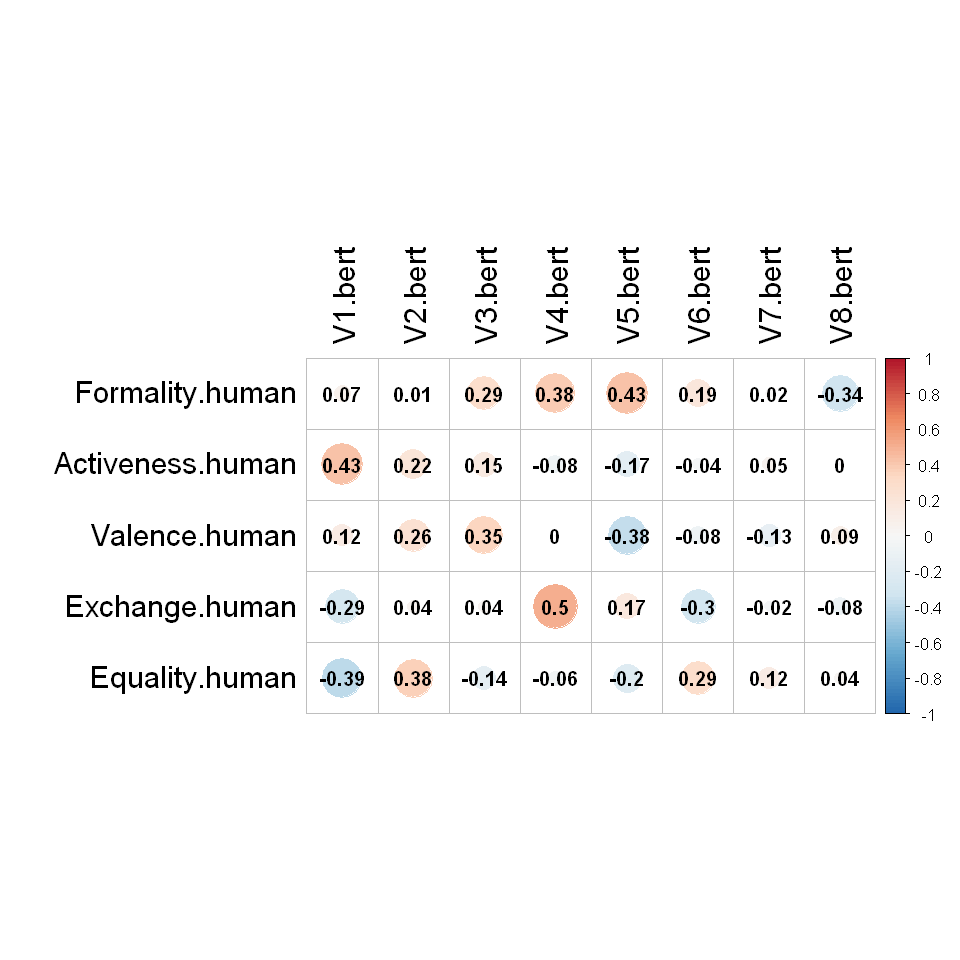

In [40]:
ncomp = 8
dim_rel.pca = prcomp(bert_768d_ancient)
loadings_none = dim_rel.pca$rotation[,1:ncomp]%*% diag(dim_rel.pca$sdev,ncomp,ncomp)
scores_none = dim_rel.pca$x[,1:ncomp] 

# pca with varimax rotation
loadings_var = data.frame(varimax(loadings_none)$loadings[,])
scores_var = scale(scores_none) %*% varimax(loadings_none)$rotmat

bert_scores = data.frame(scores_var)
colnames(bert_scores) = paste0('V',seq(1,ncomp),'.bert')

bert_human_combine = cbind(human_scores_ancient,bert_scores)
bert_human_cor = cor(bert_human_combine,method='spearman')

options(repr.plot.width=8, repr.plot.height=8)
corrplot(bert_human_cor[1:5,6:length(bert_human_combine)],is.corr=FALSE,
         addCoef.col = "black",
         tl.col="black",tl.cex=1.5,
         col.lim = c(-1,1),
         col = colorRampPalette(rev(brewer.pal(n=7,name ="RdBu")))(100))

Warning message in corrplot(bert_human_cor[1:5, 6:length(bert_human_combine)], is.corr = FALSE, :
"col.lim interval too wide, please set a suitable value"


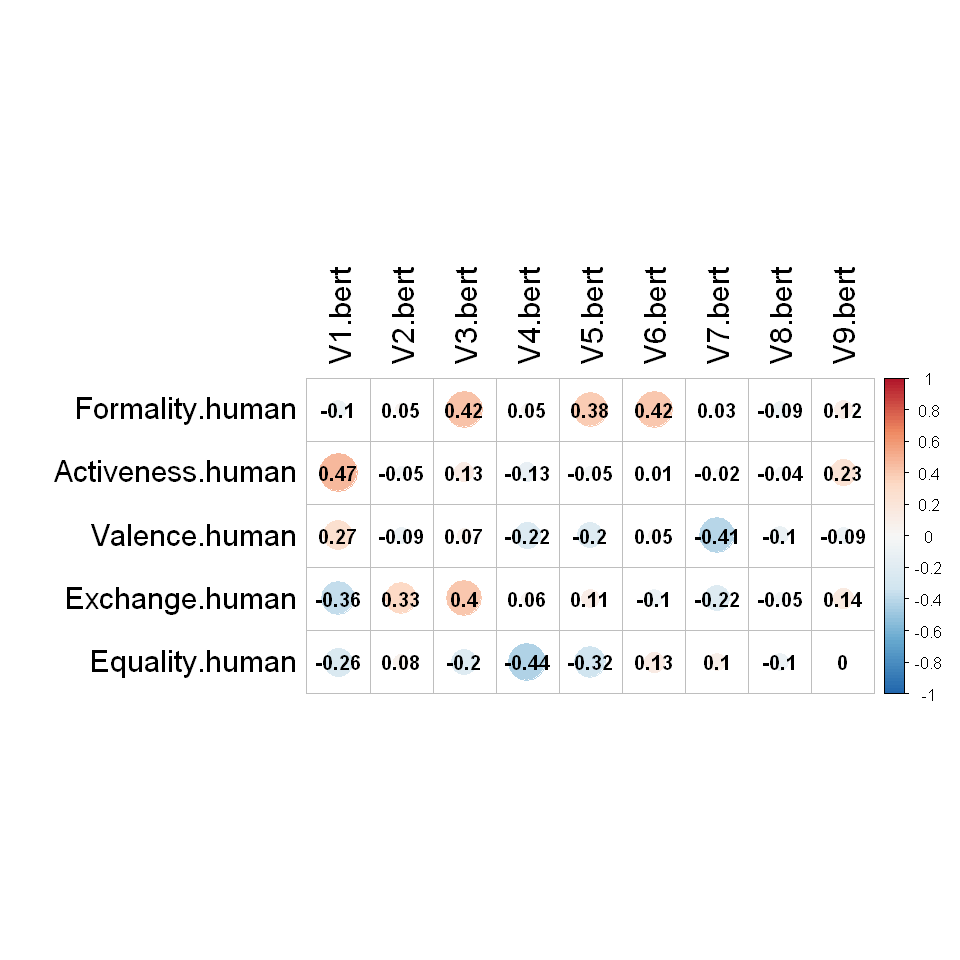

In [41]:
ncomp = 9
dim_rel.pca = prcomp(bert_768d_ancient)
loadings_none = dim_rel.pca$rotation[,1:ncomp]%*% diag(dim_rel.pca$sdev,ncomp,ncomp)
scores_none = dim_rel.pca$x[,1:ncomp] 

# pca with varimax rotation
loadings_var = data.frame(varimax(loadings_none)$loadings[,])
scores_var = scale(scores_none) %*% varimax(loadings_none)$rotmat

bert_scores = data.frame(scores_var)
colnames(bert_scores) = paste0('V',seq(1,ncomp),'.bert')

bert_human_combine = cbind(human_scores_ancient,bert_scores)
bert_human_cor = cor(bert_human_combine,method='spearman')

options(repr.plot.width=8, repr.plot.height=8)
corrplot(bert_human_cor[1:5,6:length(bert_human_combine)],is.corr=FALSE,
         addCoef.col = "black",
         tl.col="black",tl.cex=1.5,
         col.lim = c(-1,1),
         col = colorRampPalette(rev(brewer.pal(n=7,name ="RdBu")))(100))

Warning message in corrplot(bert_human_cor[1:5, 6:length(bert_human_combine)], is.corr = FALSE, :
"col.lim interval too wide, please set a suitable value"


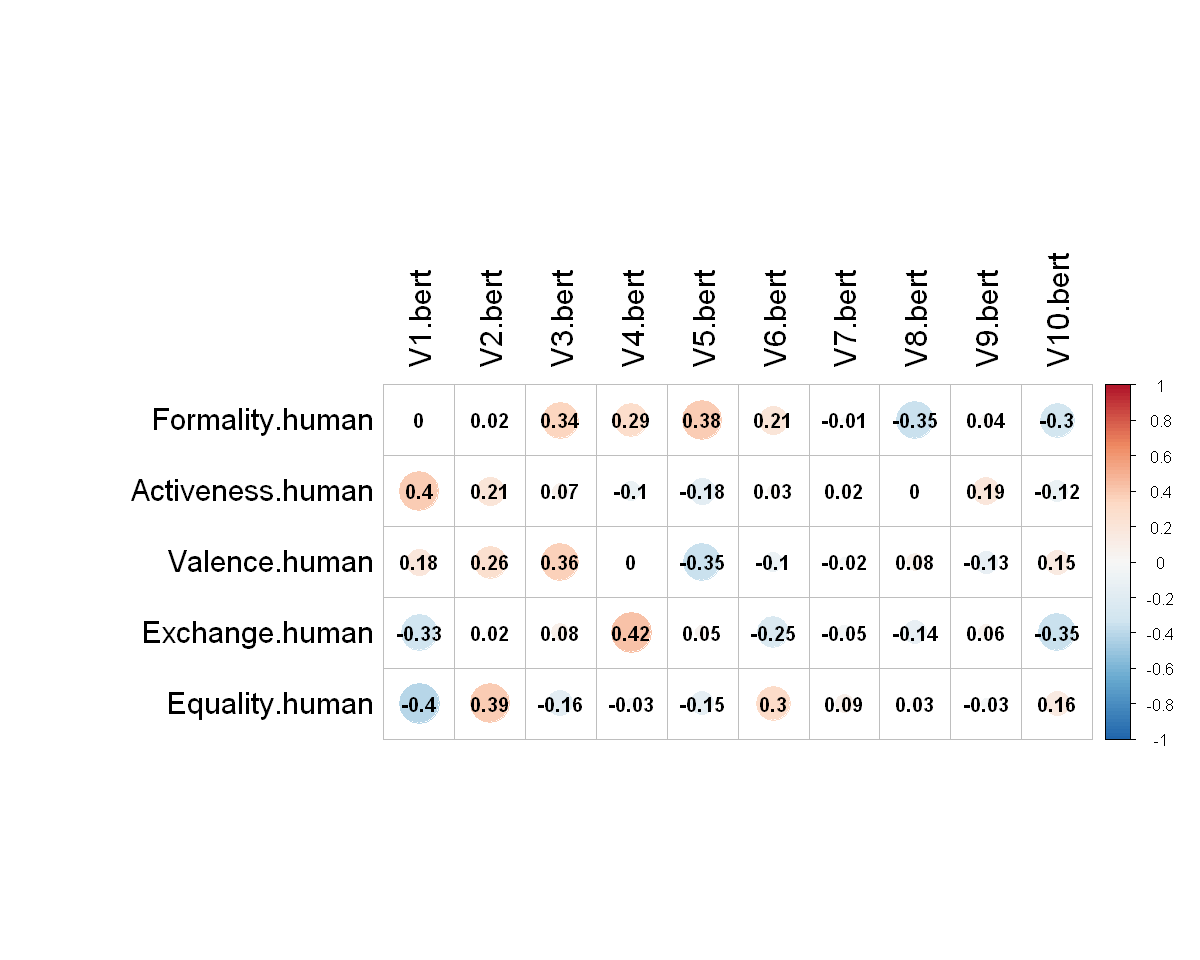

In [42]:
ncomp = 10
dim_rel.pca = prcomp(bert_768d_ancient)
loadings_none = dim_rel.pca$rotation[,1:ncomp]%*% diag(dim_rel.pca$sdev,ncomp,ncomp)
scores_none = dim_rel.pca$x[,1:ncomp] 

# pca with varimax rotation
loadings_var = data.frame(varimax(loadings_none)$loadings[,])
scores_var = scale(scores_none) %*% varimax(loadings_none)$rotmat

bert_scores = data.frame(scores_var)
colnames(bert_scores) = paste0('V',seq(1,ncomp),'.bert')

bert_human_combine = cbind(human_scores_ancient,bert_scores)
bert_human_cor = cor(bert_human_combine,method='spearman')

options(repr.plot.width=10, repr.plot.height=8)
corrplot(bert_human_cor[1:5,6:length(bert_human_combine)],is.corr=FALSE,
         addCoef.col = "black",
         tl.col="black",tl.cex=1.5,
         col.lim = c(-1,1),
         col = colorRampPalette(rev(brewer.pal(n=7,name ="RdBu")))(100))

### 33 dimension

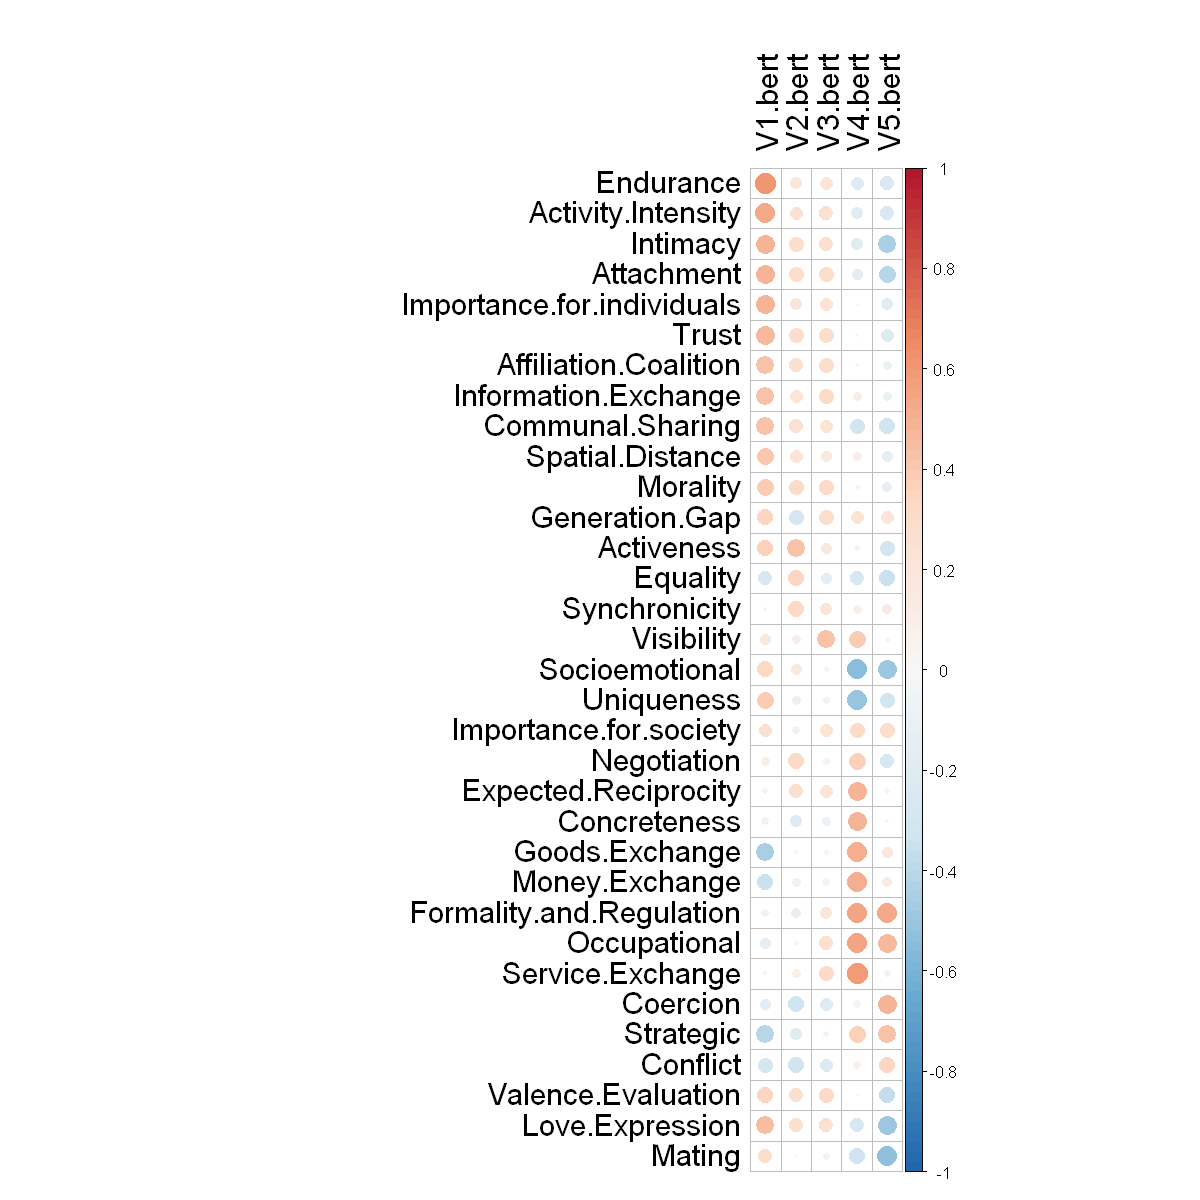

In [43]:
ncomp = 5
dim_rel.pca = prcomp(bert_768d_ancient)
loadings_none = dim_rel.pca$rotation[,1:ncomp]%*% diag(dim_rel.pca$sdev,ncomp,ncomp)
scores_none = dim_rel.pca$x[,1:ncomp] 

# pca with varimax rotation
loadings_var = data.frame(varimax(loadings_none)$loadings[,])
scores_var = scale(scores_none) %*% varimax(loadings_none)$rotmat

bert_scores = data.frame(scores_var)
colnames(bert_scores) = paste0('V',seq(1,ncomp),'.bert')

bert_human_combine = cbind(human_33d_ancient,bert_scores)
bert_human_cor = cor(bert_human_combine,method='spearman')
bert_loading = bert_human_cor[1:33,34:length(bert_human_combine)]
loadings_var_reorder = data.frame(bert_loading)

#filter each row's max loading, and attribute it to correspnding column.
order_list = c()
for (row in c(1:33)){
    temp_max = abs(loadings_var_reorder[row,1])
    n = 1
    for (col in c(2:5)){
        temp = abs(loadings_var_reorder[row,col])
        if (temp > temp_max){
            temp_max = temp
            n = col
        }
        
    }
    order_list[row] = n
}
loadings_var_reorder = loadings_var_reorder %>% mutate(order = order_list)
RC1 = loadings_var_reorder %>% filter(order==1) %>% arrange(desc(V1.bert))
RC2 = loadings_var_reorder %>% filter(order==2) %>% arrange(desc(V2.bert))
RC3 = loadings_var_reorder %>% filter(order==3) %>% arrange(V3.bert)
RC4 = loadings_var_reorder %>% filter(order==4) %>% arrange(V4.bert)
RC5 = loadings_var_reorder %>% filter(order==5) %>% arrange(desc(V5.bert))

loadings_var_reorder = rbind(RC1,RC2,RC3,RC4,RC5)
loadings_var_reorder = loadings_var_reorder[1:5]

options(repr.plot.width=10, repr.plot.height=10)
corrplot(as.matrix(loadings_var_reorder),is.corr=FALSE,
         #addCoef.col = "black",
         tl.col="black",tl.cex=1.5,
         cl.ratio = 0.5,
         col.lim = c(-1,1),
         col = colorRampPalette(rev(brewer.pal(n=7,name ="RdBu")))(100))

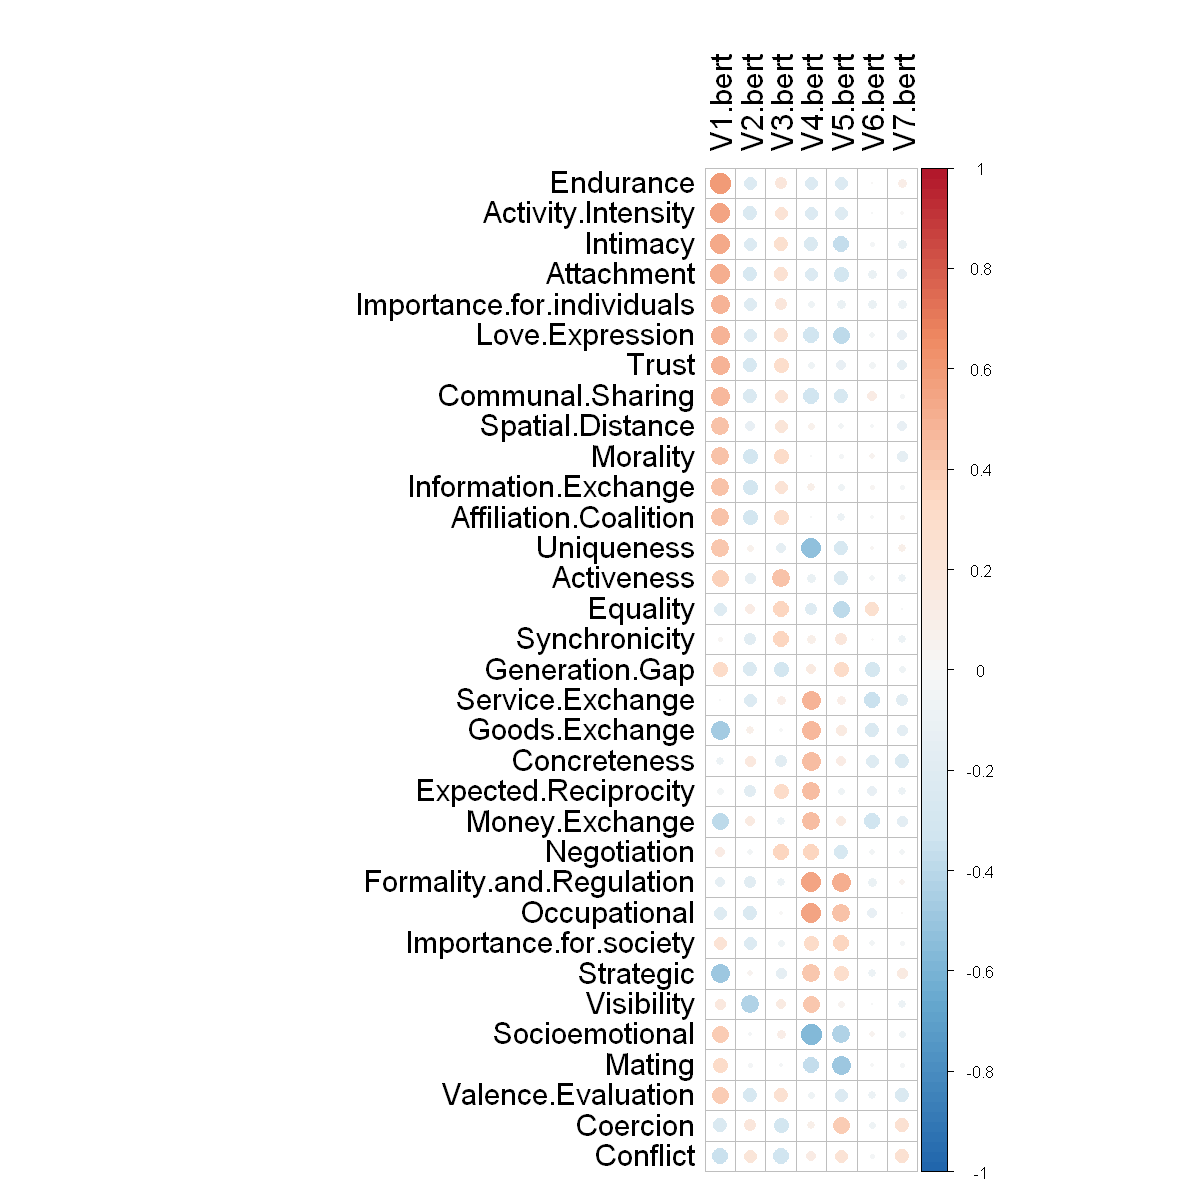

In [44]:
ncomp = 7
dim_rel.pca = prcomp(bert_768d_ancient)
loadings_none = dim_rel.pca$rotation[,1:ncomp]%*% diag(dim_rel.pca$sdev,ncomp,ncomp)
scores_none = dim_rel.pca$x[,1:ncomp] 

# pca with varimax rotation
loadings_var = data.frame(varimax(loadings_none)$loadings[,])
scores_var = scale(scores_none) %*% varimax(loadings_none)$rotmat

bert_scores = data.frame(scores_var)
colnames(bert_scores) = paste0('V',seq(1,ncomp),'.bert')

bert_human_combine = cbind(human_33d_ancient,bert_scores)
bert_human_cor = cor(bert_human_combine,method='spearman')
bert_loading = bert_human_cor[1:33,34:length(bert_human_combine)]
loadings_var_reorder = data.frame(bert_loading)

#filter each row's max loading, and attribute it to correspnding column.
order_list = c()
for (row in c(1:33)){
    temp_max = abs(loadings_var_reorder[row,1])
    n = 1
    for (col in c(2:7)){
        temp = abs(loadings_var_reorder[row,col])
        if (temp > temp_max){
            temp_max = temp
            n = col
        }
        
    }
    order_list[row] = n
}
loadings_var_reorder = loadings_var_reorder %>% mutate(order = order_list)
loadings_var_reorder['Activeness','order'] = 1
loadings_var_reorder['Uniqueness','order'] = 1

loadings_var_reorder['Equality','order'] = 3
loadings_var_reorder['Strategic','order'] = 5
loadings_var_reorder['Visibility','order'] = 5
loadings_var_reorder['Formality.and.Regulation','order'] = 5
loadings_var_reorder['Socioemotional','order'] = 5
loadings_var_reorder['Occupational','order'] = 5

loadings_var_reorder['Valence.Evaluation','order'] = 7
loadings_var_reorder['Conflict','order'] = 7
loadings_var_reorder['Coercion','order'] = 7

RC1 = loadings_var_reorder %>% filter(order==1) %>% arrange(desc(V1.bert))
RC2 = loadings_var_reorder %>% filter(order==2) %>% arrange(desc(V2.bert))
RC3 = loadings_var_reorder %>% filter(order==3) %>% arrange(desc(V3.bert))
RC4 = loadings_var_reorder %>% filter(order==4) %>% arrange(desc(V4.bert))
RC5 = loadings_var_reorder %>% filter(order==5) %>% arrange(desc(V5.bert))
RC6 = loadings_var_reorder %>% filter(order==6) %>% arrange(desc(V6.bert))
RC7 = loadings_var_reorder %>% filter(order==7) %>% arrange(V7.bert)

loadings_var_reorder = rbind(RC1,RC2,RC3,RC4,RC5,RC6,RC7)
loadings_var_reorder = loadings_var_reorder[1:7]

options(repr.plot.width=10, repr.plot.height=10)
corrplot(as.matrix(loadings_var_reorder),is.corr=FALSE,
         #addCoef.col = "black",
         tl.col="black",tl.cex=1.5,
         cl.ratio = 0.5,
         col.lim = c(-1,1),
         col = colorRampPalette(rev(brewer.pal(n=7,name ="RdBu")))(100))

### FAVEE (ancient expert)

In [23]:
expert_scores = read.csv('../../Expert_reliability/output_data/favee_hpp_results/expert_120r_scores.csv',
                         row.names=1)
colnames(expert_scores) = paste0(colnames(expert_scores),'.human')

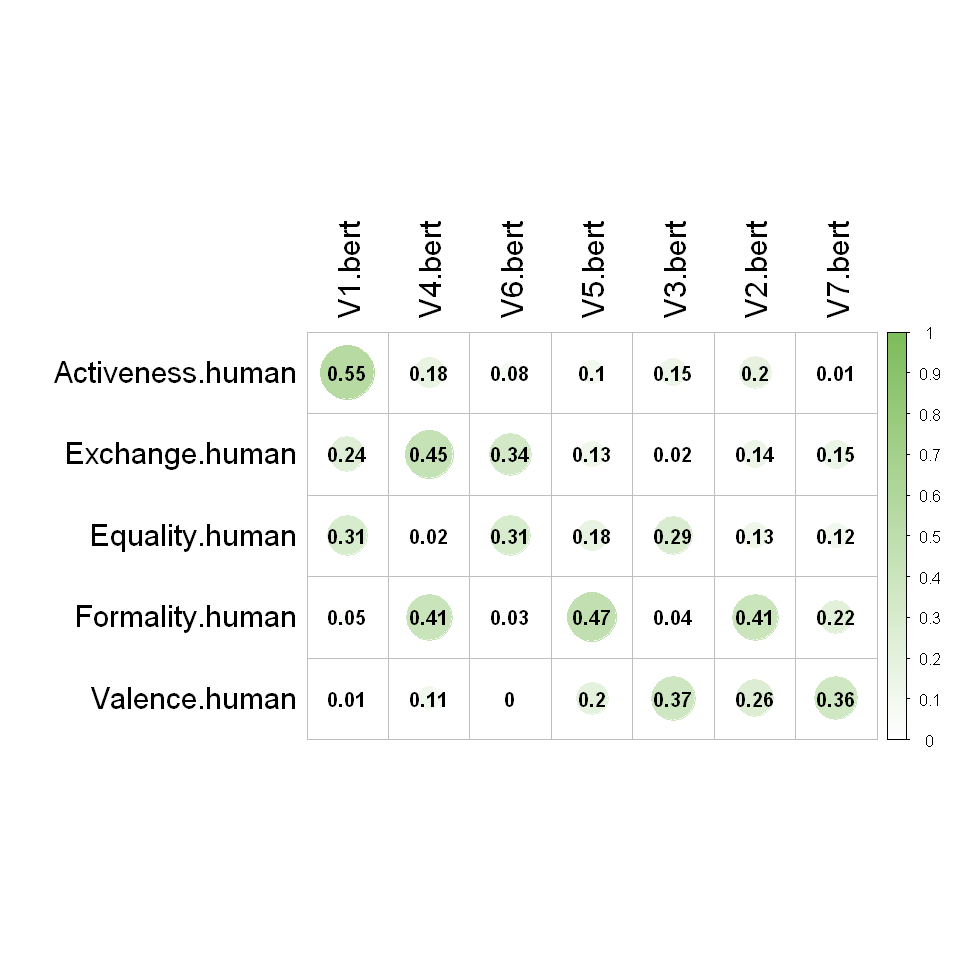

In [27]:
ncomp = 7
dim_rel.pca = prcomp(bert_768d_ancient)
loadings_none = dim_rel.pca$rotation[,1:ncomp]%*% diag(dim_rel.pca$sdev,ncomp,ncomp)
scores_none = dim_rel.pca$x[,1:ncomp] 

# pca with varimax rotation
loadings_var = data.frame(varimax(loadings_none)$loadings[,])
scores_var = scale(scores_none) %*% varimax(loadings_none)$rotmat

bert_scores = data.frame(scores_var)
colnames(bert_scores) = paste0('V',seq(1,ncomp),'.bert')

bert_human_combine = cbind(expert_scores,bert_scores)
bert_human_cor = cor(bert_human_combine,method='spearman')
bert_scores_ancient = bert_scores

options(repr.plot.width=8, repr.plot.height=8)
plot_scores_ancient = abs(bert_human_cor[1:5,6:length(bert_human_combine)])
plot_scores_ancient = plot_scores_ancient[
              paste0(c('Activeness','Exchange','Equality','Formality','Valence'),'.human'),
                      paste0('V',c(1,4,6,5,3,2,7),'.bert')]
corrplot(plot_scores_ancient,is.corr=FALSE,
         addCoef.col = "black",
         tl.col="black",tl.cex=1.5,
         col.lim = c(0,1),
        col = colorRampPalette(c("white","#7EBD5B"))(100))